In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import os
from numba import njit

import mplhep as hep
plt.style.use(hep.style.CMS)

In [3]:
inputfile = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/input_truth/electrons/electron_126X_mcRun3_2023_forPU65_v4.hdf5"
outputdir = "/eos/user/j/jabrunne/www/ECAL/Clustering/DeepCluster/validation_sim_truth/V2/simfraction_electron"
os.makedirs(outputdir, exist_ok=True)


In [4]:
store_ele = pd.HDFStore(inputfile, "r")
df =store_ele['df']
store_ele.close()
df.rename(columns={"output.csv":"window_index"}, inplace=True)
df = df.iloc[:-1]

In [5]:
from joblib import Parallel, delayed
import multiprocessing

def applyParallel(dfGrouped, func):
    retLst = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(func)(group) for name, group in dfGrouped)
    return pd.DataFrame(retLst)

In [6]:
!ls /eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/input_truth/electrons/

calo_matched_clusters_dataset_v2.hdf5
electron_126X_mcRun3_2023_forPU65_v4.hdf5


# Having a look at the dataset
It contains all the cluster around each caloparticle. 
Both the clusters inside and output the "dynamic window" limits are included, so that all the truth level info can be analyzed.

In [7]:
df

window_index           en          et  ieta   iphi       eta       phi  \
0          vauewybn  1461.322021  400.582994  72.0   28.0 -1.967984 -0.806309   
1          vauewybn    14.056093    3.829461  69.0   26.0 -1.974384 -0.910589   
2          vauewybn     1.790000    0.484696  76.0   34.0 -1.980740 -0.570572   
3          imtlgtzg   980.092163  464.190222  80.0  127.0  1.379012  2.039332   
4          imtlgtzg     6.295757    2.957995  80.0  124.0  1.388099  1.976505   
...             ...          ...         ...   ...    ...       ...       ...   
266424     ftvtvgxr     2.017130    1.113829  69.0  330.0  1.200219 -0.697570   
266425     ftvtvgxr     0.589299    0.320779  70.0  305.0  1.217331 -1.140308   
266426     ftvtvgxr     0.488165    0.250529  74.0  302.0  1.286723 -1.192264   
266427     kgngqgsg   551.019165   86.939687  53.0   68.0 -2.533420  1.405938   
266428     jkfvsbyu   256.860382  148.467332 -66.0   37.0 -1.144821  0.461701   

         iz  simfrac_sig    simen_sig  ...  obsPU   calo_simen  calo_simet  \
0      -1.0     0.973617  1415.653758  ...   53.0  1453.862061  398.526620   
1      -1.0     0.007766    11.291927  ...   53.0  1453.862061  398.526620   
2      -1.0     0.001280     1.860809  ...   53.0  1453.862061  398.526620   
3       0.0     0.982251   955.302776  ...   53.0   972.557068  460.617251   
4       0.0     0.006165     5.996112  ...   53.0   972.557068  460.617251   
...     ...          ...          ...  ...    ...          ...         ...   
266424  0.0     0.004427     2.501858  ...   72.0   565.069702  315.060150   
266425  0.0     0.001221     0.690118  ...   72.0   565.069702  315.060150   
266426  0.0     0.000352     0.198685  ...   72.0   565.069702  315.060150   
266427 -1.0     0.907608   507.963459  ...   72.0   559.469238   88.288921   
266428  0.0     0.954257   247.653133  ...   72.0   259.517578  149.988402   

        calo_simen_good  calo_geneta  calo_genphi  calo_simeta  calo_simphi  \
0           1453.806641    -1.989631    -0.808272    -1.968014    -0.806430   
1           1453.806641    -1.989631    -0.808272    -1.968014    -0.806430   
2           1453.806641    -1.989631    -0.808272    -1.968014    -0.806430   
3            972.522888     1.355173     2.039681     1.379022     2.039449   
4            972.522888     1.355173     2.039681     1.379022     2.039449   
...                 ...          ...          ...          ...          ...   
266424       563.196533     1.199331    -0.857723     1.188576    -0.853554   
266425       563.196533     1.199331    -0.857723     1.188576    -0.853554   
266426       563.196533     1.199331    -0.857723     1.188576    -0.853554   
266427       559.427734    -2.526739     1.410275    -2.533236     1.405783   
266428       259.500885    -1.129910     0.465297    -1.144942     0.461510   

         calo_genen  calo_genet  
0       1499.310791  402.522127  
1       1499.310791  402.522127  
2       1499.310791  402.522127  
3        999.099182  483.201063  
4        999.099182  483.201063  
...             ...         ...  
266424   690.383728  381.502195  
266425   690.383728  381.502195  
266426   690.383728  381.502195  
266427   607.953552   96.557628  
266428   304.472046  178.135106  

[7622005 rows x 27 columns]

# Building the window

Collecting all the clusters around the same seed by the window_index columns. 
The `calo_match_dataset.py` script collects all the clusters with some caloparticle deposition around each seed. 
The seed in this case is the PFCluster with the highest score for each caloparticle. 

In [8]:
seed = df[(df.is_seed==1)][['window_index','en','eta','et', 'simfrac_sig']]
seed.columns = ['window_index','seed_en','seed_eta','seed_et','seed_simfrac_sig']

dfa = df.join(seed.set_index("window_index"), on='window_index')

# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)

In [9]:
dfa.columns

Index(['window_index', 'en', 'et', 'ieta', 'iphi', 'eta', 'phi', 'iz',
       'simfrac_sig', 'simen_sig', 'simen_sig_frac', 'nxtals', 'is_seed',
       'in_window', 'deta_seed', 'dphi_seed', 'nVtx', 'obsPU', 'calo_simen',
       'calo_simet', 'calo_simen_good', 'calo_geneta', 'calo_genphi',
       'calo_simeta', 'calo_simphi', 'calo_genen', 'calo_genet', 'seed_en',
       'seed_eta', 'seed_et', 'seed_simfrac_sig'],
      dtype='object')

In [10]:
x = dfa[['en', 'seed_en']]
x.head(10)

en      seed_en
0  1461.322021  1461.322021
1    14.056093  1461.322021
2     1.790000  1461.322021
3   980.092163   980.092163
4     6.295757   980.092163
5   546.056580   546.056580
6    93.517075    93.517075
7     2.087033    93.517075
8  1543.985962  1543.985962
9   804.933411   804.933411

(array([[ 43.,   0.,   0., ...,   0.,   0.,   0.],
        [ 40., 114.,  18., ...,   0.,   0.,   0.],
        [  0., 116., 318., ...,   0.,   0.,   0.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   4.,   0.,   0.]]),
 array([  1.  ,   3.78,   6.56,   9.34,  12.12,  14.9 ,  17.68,  20.46,
         23.24,  26.02,  28.8 ,  31.58,  34.36,  37.14,  39.92,  42.7 ,
         45.48,  48.26,  51.04,  53.82,  56.6 ,  59.38,  62.16,  64.94,
         67.72,  70.5 ,  73.28,  76.06,  78.84,  81.62,  84.4 ,  87.18,
         89.96,  92.74,  95.52,  98.3 , 101.08, 103.86, 106.64, 109.42,
        112.2 , 114.98, 117.76, 120.54, 123.32, 126.1 , 128.88, 131.66,
        134.44, 137.22, 140.  ]),
 array([  0.        ,   4.36666667,   8.73333333,  13.1       ,
         17.46666667,  21.83333333,  26.2       ,  30.56666667,
         34.93333333,  39.3       ,  43.66666667,  48.03333333,
         52.4       ,

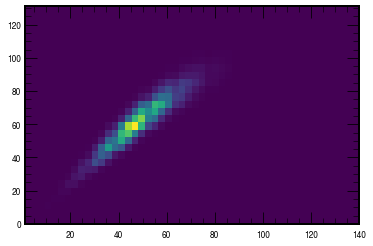

In [11]:
plt.hist2d(dfb[dfb.is_seed==1].nVtx, dfb[dfb.is_seed==1].obsPU, bins=(50, 30))

(array([1.59000e+02, 1.31300e+03, 4.39000e+03, 1.93260e+04, 4.55780e+04,
        1.28045e+05, 2.29696e+05, 4.84886e+05, 6.06445e+05, 8.08414e+05,
        7.12725e+05, 4.23338e+05, 2.75676e+05, 1.07387e+05, 4.75560e+04,
        1.31390e+04, 4.46100e+03, 8.57000e+02, 1.89000e+02, 2.60000e+01]),
 array([  0.  ,   6.55,  13.1 ,  19.65,  26.2 ,  32.75,  39.3 ,  45.85,
         52.4 ,  58.95,  65.5 ,  72.05,  78.6 ,  85.15,  91.7 ,  98.25,
        104.8 , 111.35, 117.9 , 124.45, 131.  ]),
 <BarContainer object of 20 artists>)

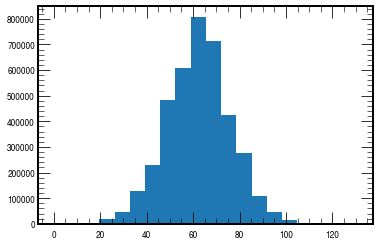

In [12]:
plt.hist(dfb[dfb.is_seed==1].obsPU, bins=20)

(array([2.820000e+02, 2.403000e+03, 8.047000e+03, 3.494200e+04,
        8.261800e+04, 2.355410e+05, 4.276720e+05, 9.134370e+05,
        1.154134e+06, 1.555889e+06, 1.390098e+06, 8.357730e+05,
        5.511560e+05, 2.170320e+05, 9.798100e+04, 2.686700e+04,
        9.391000e+03, 1.771000e+03, 4.350000e+02, 7.000000e+01]),
 array([  0.  ,   6.55,  13.1 ,  19.65,  26.2 ,  32.75,  39.3 ,  45.85,
         52.4 ,  58.95,  65.5 ,  72.05,  78.6 ,  85.15,  91.7 ,  98.25,
        104.8 , 111.35, 117.9 , 124.45, 131.  ]),
 <BarContainer object of 20 artists>)

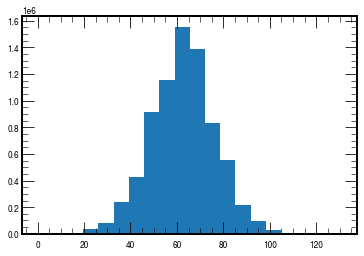

In [13]:
plt.hist(dfb.obsPU, bins=20)

(array([3645., 9499., 9286., 8726., 7823., 7234., 6947., 6736., 6557.,
        6270., 6128., 6059., 5957., 5865., 5748., 5528., 5290., 5283.,
        5320., 5032., 5063., 4967., 4832., 4866., 4941., 4747., 4654.,
        4589., 4589., 4529., 4301., 4434., 4319., 4348., 4253., 4288.,
        4194., 4059., 4075., 4051., 4005., 3970., 4009., 4048., 3806.,
        3980., 3814., 3708., 3922., 3810.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
        13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
        17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ]),
 <BarContainer object of 50 artists>)

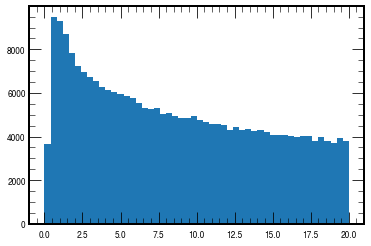

In [14]:
plt.hist(dfb[dfb.is_seed==1].seed_et, bins=50, range=(0,20))

(array([[112.,  40.,  43., ...,  76.,  13.,   0.],
        [815., 248., 320., ..., 249., 180., 638.],
        [519., 218., 304., ..., 297., 240., 338.],
        ...,
        [200., 229., 245., ..., 233., 251., 236.],
        [203., 249., 247., ..., 267., 264., 223.],
        [236., 200., 230., ..., 230., 223., 196.]]),
 array([ 0. ,  0.8,  1.6,  2.4,  3.2,  4. ,  4.8,  5.6,  6.4,  7.2,  8. ,
         8.8,  9.6, 10.4, 11.2, 12. , 12.8, 13.6, 14.4, 15.2, 16. , 16.8,
        17.6, 18.4, 19.2, 20. , 20.8, 21.6, 22.4, 23.2, 24. , 24.8, 25.6,
        26.4, 27.2, 28. , 28.8, 29.6, 30.4, 31.2, 32. , 32.8, 33.6, 34.4,
        35.2, 36. , 36.8, 37.6, 38.4, 39.2, 40. ]),
 array([-3. , -2.8, -2.6, -2.4, -2.2, -2. , -1.8, -1.6, -1.4, -1.2, -1. ,
        -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,
         1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ]),
 <matplotlib.collections.QuadMesh at 0x7f82aed03fd0>)

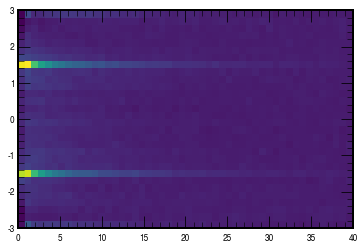

In [15]:
plt.hist2d(dfb[dfb.is_seed==1].seed_et, dfb[dfb.is_seed==1].seed_eta, bins=(50, 30), range=((0,40), (-3,3)))

# Window dimension study

In [16]:
H, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

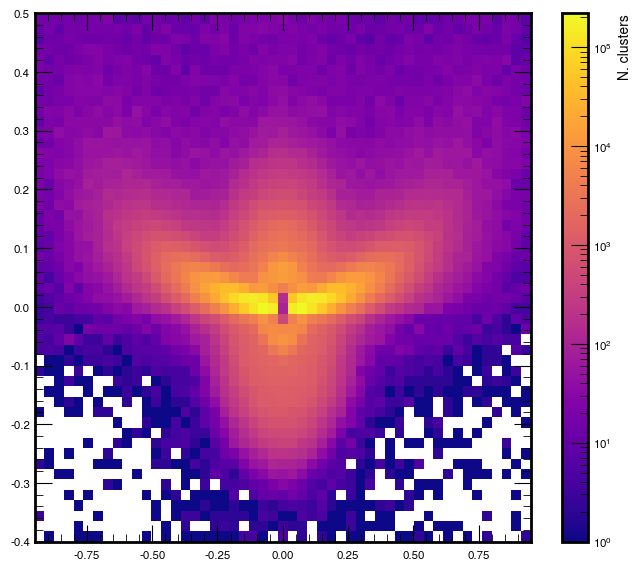

In [22]:
plt.figure(figsize=(8,7), dpi=100)
I = plt.pcolormesh(X, Y, H.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(I, label="N. clusters")

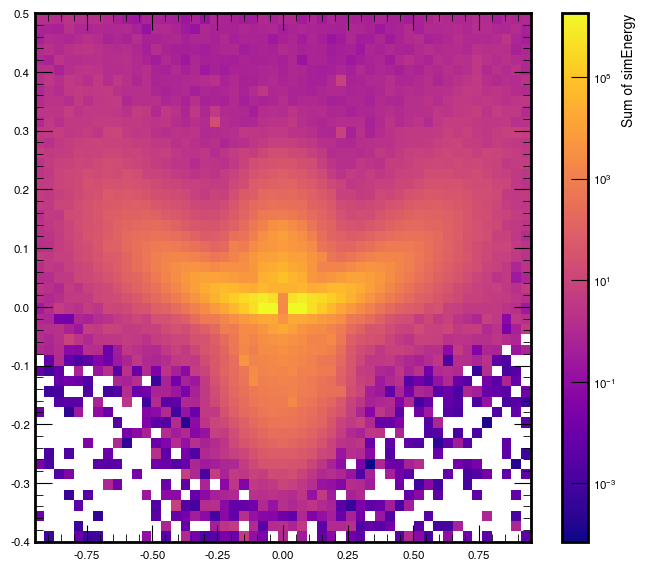

In [21]:
plt.figure(figsize=(8,7), dpi=100)

I = plt.pcolormesh(X, Y, Hfrac.T, norm=LogNorm(), cmap="plasma")
plt.colorbar(label="Sum of simEnergy")

Plotting the normalized distribution of the profiled simEnergy in each bin

/tmp/ipykernel_930/4061902690.py:2: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)


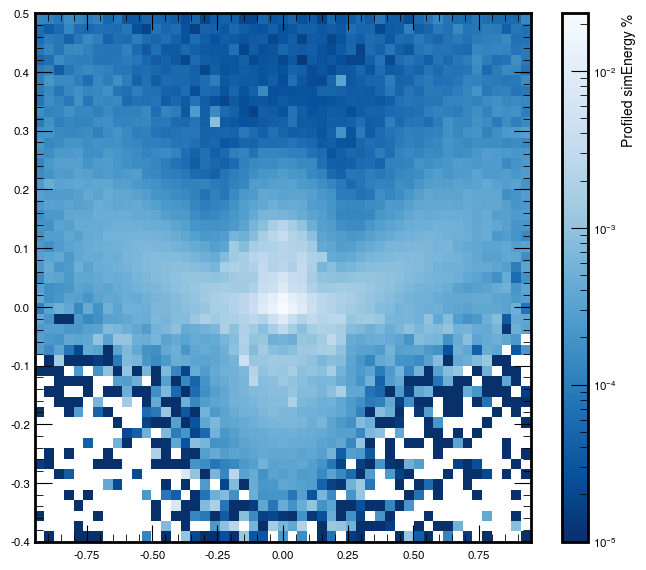

In [22]:
plt.figure(figsize=(8,7), dpi=100)
profile_simen = (Hfrac/H)
np.nan_to_num(profile_simen, copy=False, nan=0.)
prof_simen_perc = profile_simen / np.sum(profile_simen)

I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy %")

#$plt.gca().set_xticklabels(phibins)

Plotting the normalized distribution of the profiled simEnergy/caloEn in each bin

/tmp/ipykernel_930/2531401568.py:10: RuntimeWarning: invalid value encountered in divide
  profile_simen2 = (Hfrac2/H2)


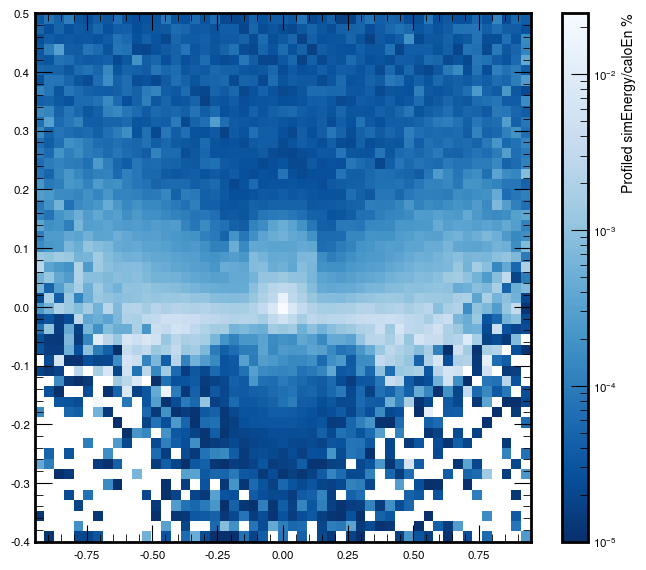

In [23]:
H2, phibins , etabins  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))
Hfrac2, _ ,_  = np.histogram2d(dfb[dfb.is_seed==0].dphi_seed, dfb[dfb.is_seed==0].deta_seed, 
                              weights=dfb[dfb.is_seed==0].simen_sig/dfb[dfb.is_seed==0].calo_simen_good, 
                          range=((-0.95, 0.95), (-0.4, 0.5)), bins=(51,51))

X, Y = np.meshgrid(phibins, etabins)

plt.figure(figsize=(8,7), dpi=100)
profile_simen2 = (Hfrac2/H2)
np.nan_to_num(profile_simen2, copy=False, nan=0.)
prof_simen_perc2 = profile_simen2 / np.sum(profile_simen2)

I = plt.pcolormesh(X, Y, prof_simen_perc2.T, norm=LogNorm(vmin=1e-5), cmap="Blues_r")
plt.colorbar(label="Profiled simEnergy/caloEn %")

#$plt.gca().set_xticklabels(phibins)

### Studying the profile

In [24]:
import numba 
@numba.njit
def get_binrange(X, perc, direction=1):
    S = 0.
    i = 0 if direction>0 else len(X)-1
    while(S<perc):
        S += X[i]
        i += direction
    return i

Text(1, 0, 'ieta, (iphi profiled)')

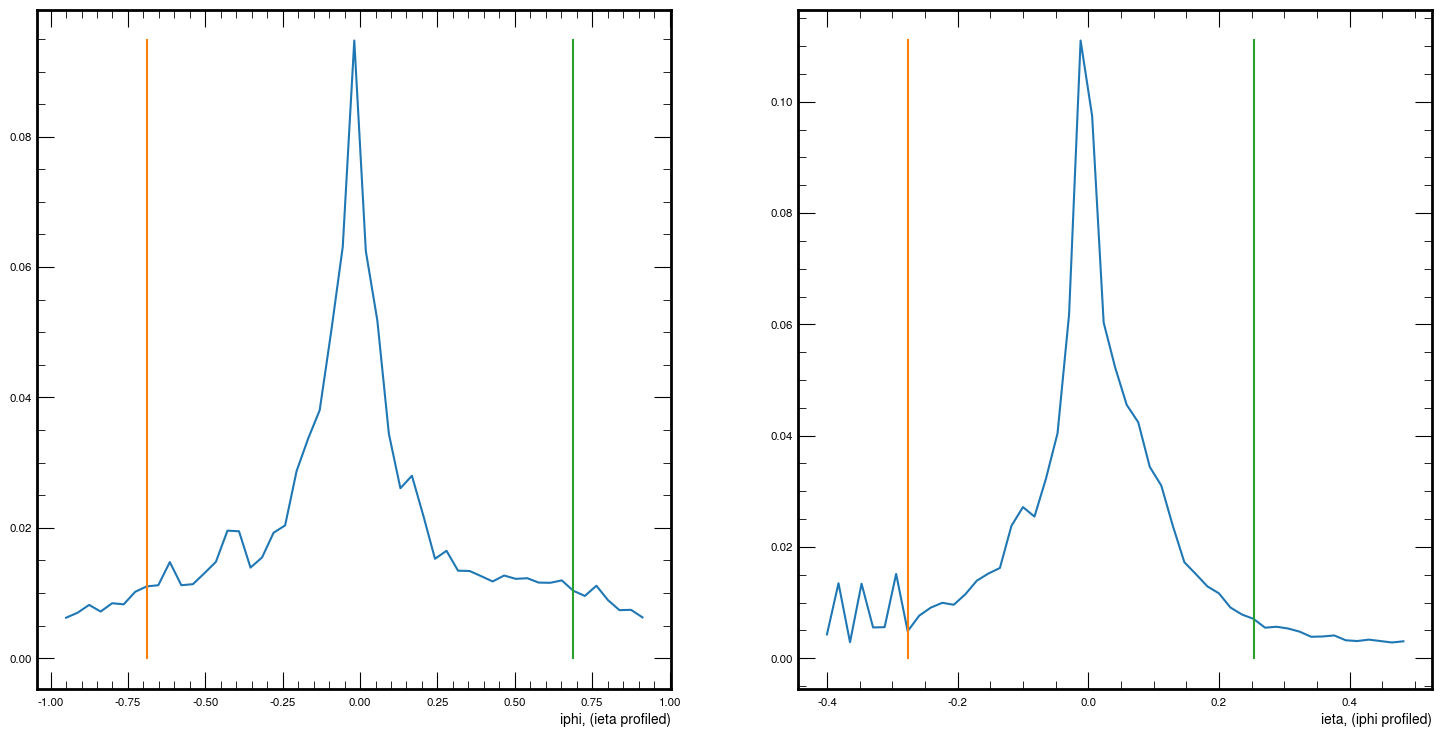

In [26]:
iphi_profile = np.sum(prof_simen_perc, axis=1)
ieta_profile = np.sum(prof_simen_perc.T, axis=1)

prob = 0.05
iphi_min =  get_binrange(iphi_profile,  prob)
iphi_max =  get_binrange(iphi_profile, prob, direction=-1)
ieta_min =  get_binrange(ieta_profile,  prob)
ieta_max =  get_binrange(ieta_profile, prob, direction=-1)

f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
a1.plot(phibins[:-1], iphi_profile)
a2.plot(etabins[:-1], ieta_profile)
a1.plot([phibins[iphi_min], phibins[iphi_min]], [0,np.max(iphi_profile)])
a1.plot([phibins[iphi_max], phibins[iphi_max]], [0,np.max(iphi_profile)])
a2.plot([etabins[ieta_min], etabins[ieta_min]], [0,np.max(ieta_profile)])
a2.plot([etabins[ieta_max], etabins[ieta_max]], [0,np.max(ieta_profile)])

a1.set_xlabel("iphi, (ieta profiled)")
a2.set_xlabel("ieta, (iphi profiled)")

## Now we do the same in bins of eta

In [13]:
eta_bins_wind = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0, 2.4, 3.0]

dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))

/tmp/ipykernel_834/1576785483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), eta_bins_wind, labels=list(range(len(eta_bins_wind)-1)))


### Plotting simEn profiles

/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_834/4240029626.py:16: RuntimeWarning: invalid val

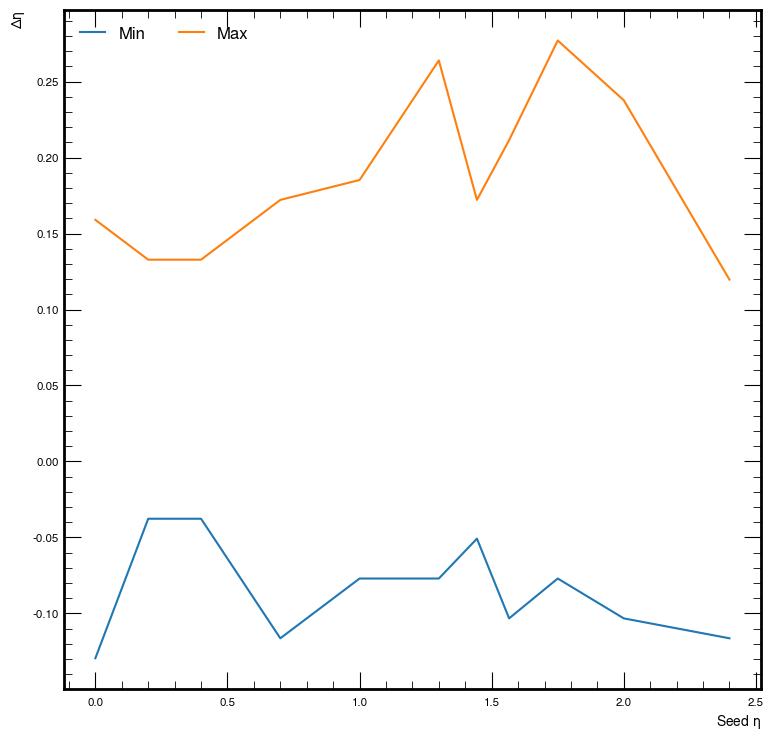

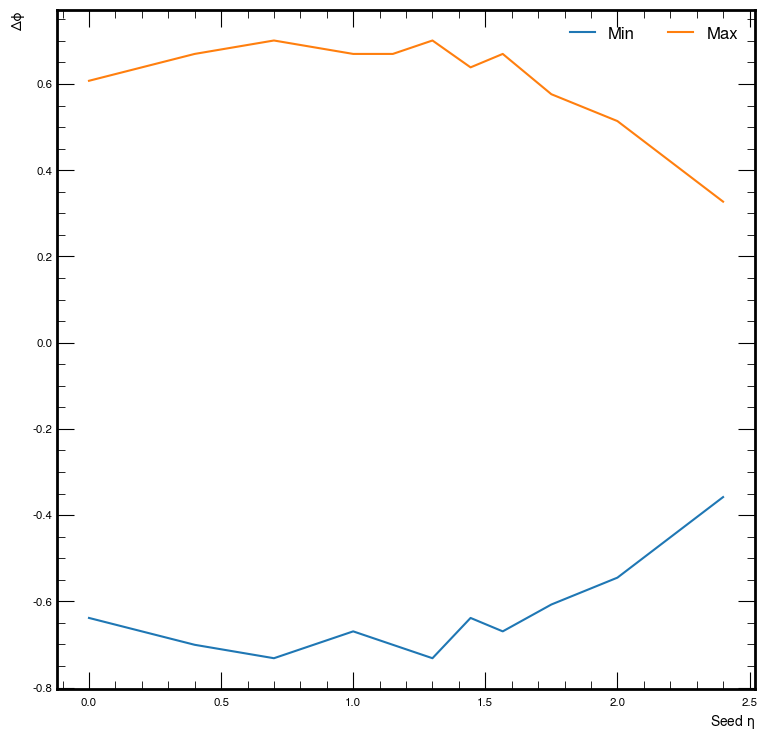

In [14]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig,  # --> simEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Plotting by simEn/CaloEn profiled

/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_753/3877013058.py:16: RuntimeWarning: invalid val

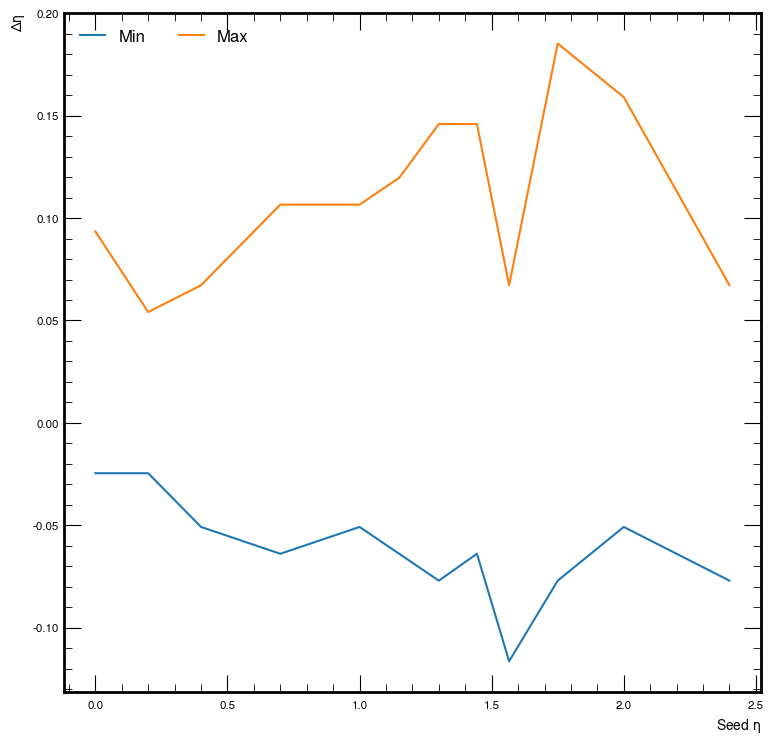

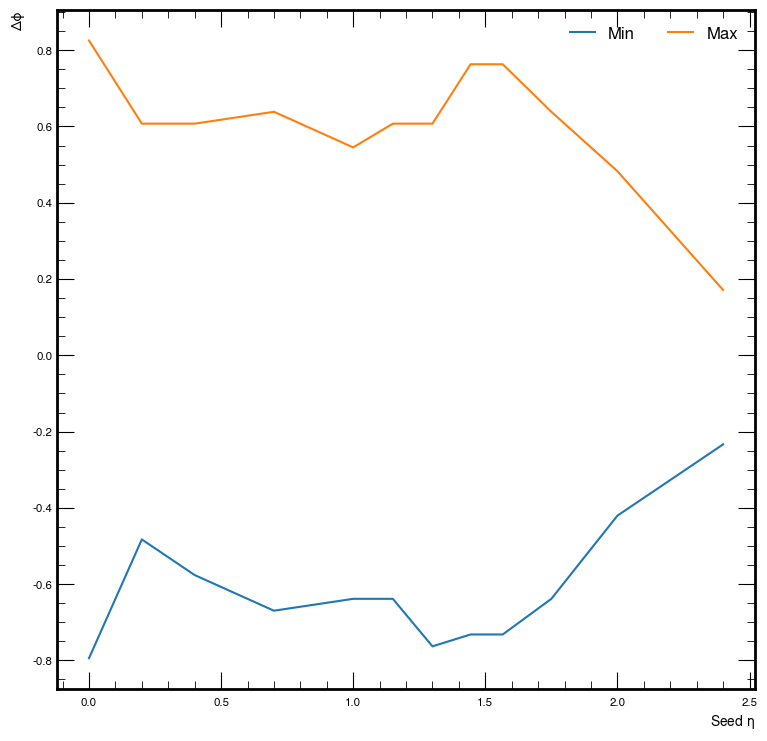

In [16]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_analysis(prob_phi, prob_eta):
    def f(dfs):
        df = dfs[dfs.is_seed ==0]
        H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    
        Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                                  weights=df.simen_sig/df.calo_simen_good,  # ===> simEn/CaloEN
                              range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
        
        X, Y = np.meshgrid(phibins, etabins)
        
        profile_simen = (Hfrac/H)
        np.nan_to_num(profile_simen, copy=False, nan=0.)
        prof_simen_perc = profile_simen / np.sum(profile_simen)
        
        iphi_profile = np.sum(prof_simen_perc, axis=1)
        ieta_profile = np.sum(prof_simen_perc.T, axis=1)

        iphi_min =  phibins[get_binrange(iphi_profile,  prob_phi)]
        iphi_max =  phibins[get_binrange(iphi_profile, prob_phi, direction=-1)]
        ieta_min =  etabins[get_binrange(ieta_profile,  prob_eta[0])]
        ieta_max =  etabins[get_binrange(ieta_profile, prob_eta[1], direction=-1)]
        
        
        f, (a1, a2) = plt.subplots(1,2, figsize=(18,9), dpi=100)
        a1.plot(phibins[:-1], iphi_profile)
        a2.plot(etabins[:-1], ieta_profile)
        a1.plot([iphi_min,iphi_min], [0,np.max(iphi_profile)])
        a1.plot([iphi_max, iphi_max], [0,np.max(iphi_profile)])
        a2.plot([ieta_min, ieta_min], [0,np.max(ieta_profile)])
        a2.plot([ieta_max, ieta_max], [0,np.max(ieta_profile)])
        a1.set_xlabel("iphi, (ieta profiled)")
        a2.set_xlabel("ieta, (iphi profiled)")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_profile_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
        I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
        rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                                 linewidth=2, edgecolor='orange', facecolor='none')
        ax.add_patch(rect)
        plt.colorbar(I, label="Profiled simEnergy/CaloEn %", ax=ax)
        ax.set_xlabel("$\Delta\phi$")
        ax.set_ylabel("$\Delta\eta$")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
        f.savefig(outputdirwind+f"/simen_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
        plt.close(f)
        
        return pd.Series({
            "iphi_min" : iphi_min,
            "iphi_max" : iphi_max,
            "ieta_min" : ieta_min, 
            "ieta_max" : ieta_max, 
        })
    return f


prob_phi = 0.05
prob_eta = [0.05,0.07]
res = dfb.groupby("eta_bin").apply(windows_size_analysis(prob_phi, prob_eta))
res.reset_index(level=0, inplace=True)


# Plotting the limits
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(eta_bins_wind[:-1], res.ieta_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.ieta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")
f.savefig(outputdirwind+"/wind_dimension_deta.png")
f.savefig(outputdirwind+"/wind_dimension_deta.pdf")


f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(eta_bins_wind[:-1], res.iphi_min, label="Min")
ax.plot(eta_bins_wind[:-1], res.iphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")
f.savefig(outputdirwind+"/wind_dimension_dphi.png")
f.savefig(outputdirwind+"/wind_dimension_dphi.pdf")

#### Approximate the trend as a linear function

In [15]:
def deta_window(seed_eta):
    EB_max = (0.1/1.5)*seed_eta + 0.1
    EB_min = np.ones_like(seed_eta) * (-0.1)
    EE_max = (0.1/1.5)*(seed_eta-1.5) + 0.2 
    EE_min = -0.1 + (-0.2/1.5)*(seed_eta-1.5)
    out_max = np.where(seed_eta<= 1.5, EB_max, EE_max) #upper windowbound
    out_min = np.where(seed_eta<= 1.5, EB_min, EE_min) #lower windowbound
    return out_max, out_min

@njit
def dphi_window(seed_eta):
    return 0.7 + (-0.1/3)*seed_eta,  -0.7 + (0.1/3)*seed_eta



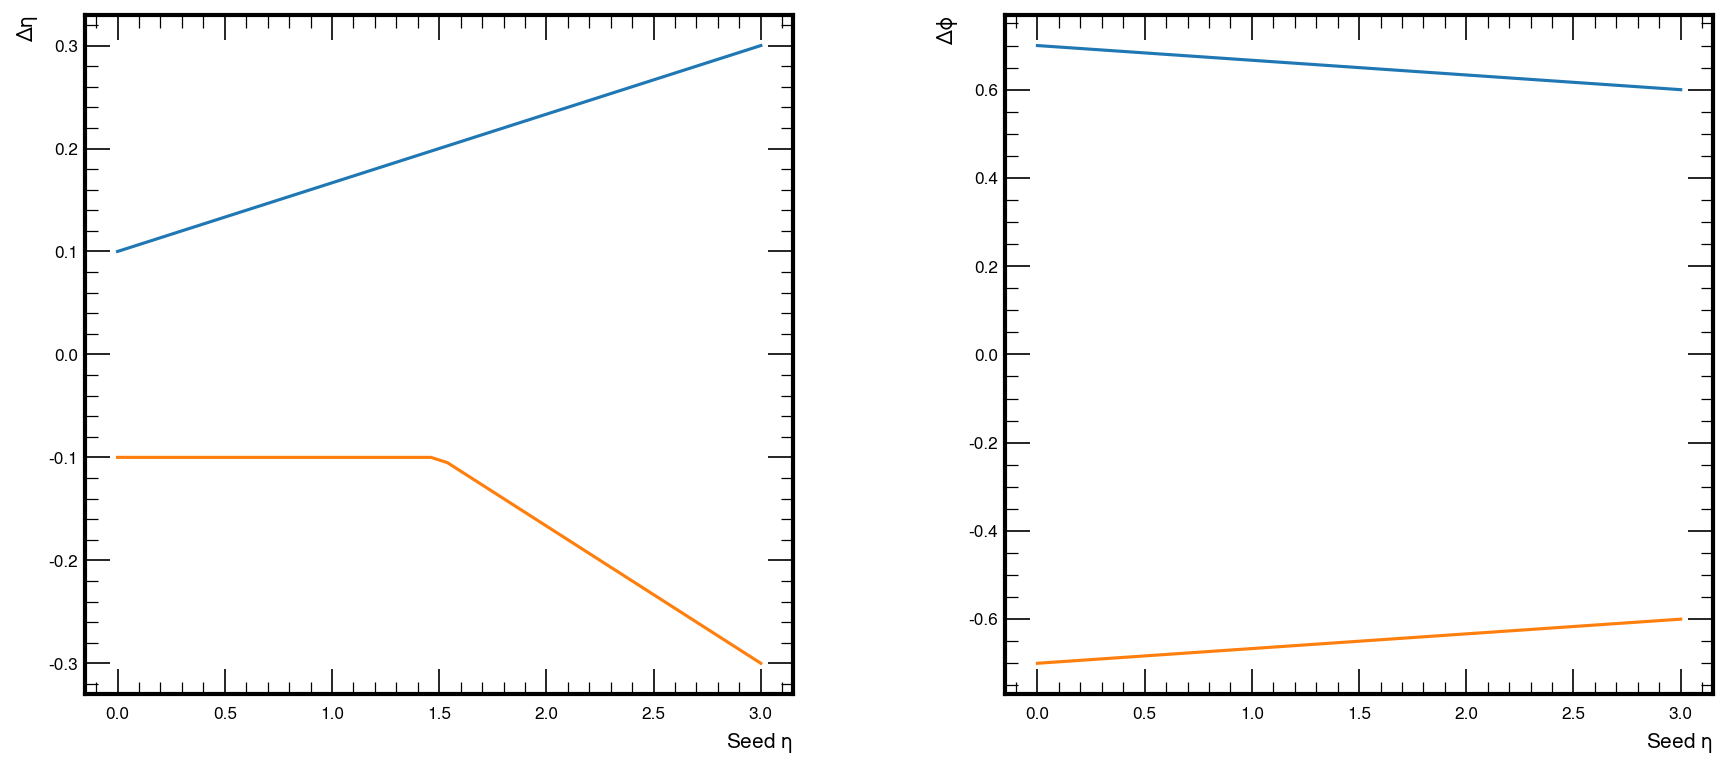

In [16]:
fig,( ax,ay) = plt.subplots(1, 2, figsize=(14, 6), dpi=150)
plt.subplots_adjust(wspace=0.3)
seta = np.linspace(0, 3, 40)
emax, emin = deta_window(seta) #upper and lower window bound for eta
pmax, pmin = dphi_window(seta)
ax.plot(seta, emax)
ax.plot(seta, emin)
ax.set_ylabel("$\Delta\eta$")
ax.set_xlabel("Seed $\eta$")

ay.plot(seta, pmax)
ay.plot(seta, pmin)
ay.set_ylabel("$\Delta\phi$")
ay.set_xlabel("Seed $\eta$")\

outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")


outputdirwind = outputdir + "/windows_simEn"
fig.savefig(outputdirwind+"/final_window.png")
fig.savefig(outputdirwind+"/final_window.pdf")

### Plots of the window with the final cut
Doing it both for simEn profile and also for simEn/CaloEn profile

In [27]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig,  # --> simEN
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/profiled_simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/profiled_simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/profiled_simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/profiled_simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/3223321510.py:14: RuntimeWarning: invalid val

Empty DataFrame
Columns: []
Index: []

In [28]:
outputdirwind = outputdir + "/windows_simEn_ov_caloEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig/df.calo_simen_good, # --> simEn/CaloEN 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    profile_simen = (Hfrac/H)
    np.nan_to_num(profile_simen, copy=False, nan=0.)
    prof_simen_perc = profile_simen / np.sum(profile_simen)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    # Profiled simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, prof_simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Profiled simEnergy/caloEn %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='orange', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encountered in divide
  profile_simen = (Hfrac/H)
/tmp/ipykernel_640/199248077.py:14: RuntimeWarning: invalid value encoun

Empty DataFrame
Columns: []
Index: []

For simEn

In [18]:
outputdirwind = outputdir + "/windows_simEn"
os.makedirs(outputdirwind, exist_ok=True)

def windows_size_final_plot(dfs):
    df = dfs[dfs.is_seed ==0]
    H, phibins , etabins  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))
    Hfrac, _ ,_  = np.histogram2d(df.dphi_seed, df.deta_seed, 
                              weights=df.simen_sig,  # --> simEN
                          range=((-0.95, 0.95), (-0.3, 0.5)), bins=(61,61))

    X, Y = np.meshgrid(phibins, etabins)

    #profile_simen = (Hfrac/H)
    np.nan_to_num(Hfrac, copy=False, nan=0.)
    simen_perc = Hfrac / np.sum(Hfrac)

    etacenter = (eta_bins_wind[dfs.eta_bin.values[0]] + eta_bins_wind[dfs.eta_bin.values[0]+1])/2
    iphi_max, iphi_min = dphi_window(etacenter)
    ieta_max, ieta_min = deta_window(etacenter)

    #simEn
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, simen_perc.T, norm=LogNorm(vmin=1e-4), cmap="Blues_r")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="simEnergy %", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    # Occupancy
    f, ax  = plt.subplots(1,1, figsize=(10,9), dpi=100)
    I = plt.pcolormesh(X, Y, H.T/np.sum(H), norm=LogNorm(vmin=1e-4), cmap="Blues")
    rect = Rectangle((iphi_min, ieta_min), (iphi_max-iphi_min) ,(ieta_max-ieta_min) , 
                             linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    plt.colorbar(I, label="Occupancy", ax=ax)
    ax.set_xlabel("$\Delta\phi$")
    ax.set_ylabel("$\Delta\eta$")
    ax.text(0.001, 1.01, f"eta{eta_bins_wind[dfs.eta_bin.values[0]]}-{eta_bins_wind[dfs.eta_bin.values[0]+1]}", transform=ax.transAxes)
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.png")
    f.savefig(outputdirwind+f"/simen_FINAL_occupancy_2d_eta{eta_bins_wind[dfs.eta_bin.values[0]]}_{eta_bins_wind[dfs.eta_bin.values[0]+1]}.pdf")
    plt.close(f)
    
    
dfb.groupby("eta_bin").apply(windows_size_final_plot)

Empty DataFrame
Columns: []
Index: []

# Resolution study

Let's study the best threshold for resolution. 
We have to apply the window definition before studying the best threshold.

Get the "seed", in this case the clusters with the highest score for the caloparticle, 
and collect the clusters around them and **apply** the geometrical window we have defined as a function of the seed eta

In [2]:
eta_max, eta_min = deta_window(dfb.seed_eta.abs().values)
phi_max, phi_min = dphi_window(dfb.seed_eta.abs().values)

dfb["in_window_new"] =  (dfb.deta_seed >= eta_min) & (dfb.deta_seed <= eta_max ) & \
                        (dfb.dphi_seed >= phi_min) & (dfb.dphi_seed <= phi_max)    

NameError: name 'deta_window' is not defined

Analyzing the truth level resolution for clusters in the geometrical window

In [31]:
def bin_analysis(group):
    ratio_left = group["EoEtrue"].quantile(0.16)
    ratio_right = group["EoEtrue"].quantile(0.84)
    ratio_mean = group[(group.EoEtrue >= ratio_left) & (group.EoEtrue <= ratio_right) ].EoEtrue.mean()
    count = group["EoEtrue"].count()
    return pd.Series(  
        { 
             "quantile_down": ratio_left,
             "quantile_up": ratio_right,
             "EoEtrue_68scale": ratio_mean,
             "EoEtrue_68width": (ratio_right-ratio_left)/2, 
             #"EoEtrue_68width": abs(ratio_right- ratio_left), 
             "EoEtrue_scale":  group.EoEtrue.mean(),
             "EoEtrue_rms":  group.EoEtrue.std(),
             "rel_err" : 1/np.sqrt(count)
        })


In [32]:
etas = [0.0, 0.2, 0.4, 0.7, 1.0, 1.15, 1.3, 1.4442, 1.566, 1.75, 2.0,2.4,3.0]
ets = [ 1,3,6,10,15,20,30,40,50,60,70,80,90,100]

In [33]:
thres = np.logspace(-4,-0.7, 60)
    
res= []
# res_all = []

#Taking all the cluster passing the simfraction threshold, or beeing the seed
for i, thr in enumerate(thres):
    print(f"{i}) SimFracr threshold: {thr}")
    
    # we select only the clusters **inside the window** and passing the threshold or being the seed.
    g = dfb[ (dfb.in_window_new) & ((dfb.simfrac_sig >  thr) | (dfb.is_seed==1))]\
            .groupby("window_index", sort=False).agg(
                        {
                         "en": 'sum' ,
                         "calo_simen_good": "first", 
                         "seed_et": "first",
                         "seed_eta": "first"
                            })
    g["EoEtrue"] = g["en"] / g["calo_simen_good"]
    g["thr"]= thr
    g["et_bin"] = pd.cut(g["seed_et"], ets, labels=list(range(len(ets)-1)))
    g["eta_bin"] = pd.cut(g["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

    scanres = g.groupby(["et_bin","eta_bin"]).apply(bin_analysis)
    #scanres = applyParallel(g.groupby(["et_bin","eta_bin"]), bin_analysis)
    scanres["thr"] = thr
    res.append(scanres)

res = pd.concat(res)
res.reset_index(level=0, inplace=True)
res.reset_index(level=0, inplace=True)

0) SimFracr threshold: 0.0001
1) SimFracr threshold: 0.00011374497075739473
2) SimFracr threshold: 0.0001293791837260057
3) SimFracr threshold: 0.0001471623146953012
4) SimFracr threshold: 0.00016738973181607556
5) SimFracr threshold: 0.0001903974015050766
6) SimFracr threshold: 0.00021656746866478862
7) SimFracr threshold: 0.00024633460390279384
8) SimFracr threshold: 0.000280193223174577
9) SimFracr threshold: 0.0003187056997641244
10) SimFracr threshold: 0.00036251170499885317
11) SimFracr threshold: 0.0004123388328430786
12) SimFracr threshold: 0.0004690146848387425
13) SimFracr threshold: 0.0005334806161177142
14) SimFracr threshold: 0.0006068073707994633
15) SimFracr threshold: 0.0006902128664695653
16) SimFracr threshold: 0.0007850824231295831
17) SimFracr threshold: 0.0008929917726101903
18) SimFracr threshold: 0.0010157332306214009
19) SimFracr threshold: 0.0011553454661434532
20) SimFracr threshold: 0.0013141473626117554
21) SimFracr threshold: 0.0014947765333118152
22) SimFr

In [34]:
res

eta_bin et_bin  quantile_down  quantile_up  EoEtrue_68scale  \
0          0      0       0.462486     0.801532         0.652270   
1          1      0       0.544966     0.805452         0.678379   
2          2      0       0.534007     0.809170         0.678699   
3          3      0       0.525886     0.799369         0.669876   
4          4      0       0.524340     0.774559         0.654087   
...      ...    ...            ...          ...              ...   
9355       7     12       0.836167     0.983310         0.920911   
9356       8     12       0.905437     0.994567         0.959530   
9357       9     12       0.947883     0.996300         0.975672   
9358      10     12       0.957866     1.000617         0.979892   
9359      11     12       0.905097     1.002729         0.954756   

      EoEtrue_68width  EoEtrue_scale  EoEtrue_rms   rel_err       thr  
0            0.169523       0.654826     0.225309  0.022027  0.000100  
1            0.130243       0.688166     0.180852  0.024218  0.000100  
2            0.137582       0.685196     0.211345  0.018496  0.000100  
3            0.136742       0.674543     0.199601  0.017461  0.000100  
4            0.125109       0.657187     0.146876  0.023045  0.000100  
...               ...            ...          ...       ...       ...  
9355         0.073571       0.912641     0.169819  0.018346  0.199526  
9356         0.044565       0.960877     0.157803  0.014097  0.199526  
9357         0.024208       0.971422     0.037123  0.012106  0.199526  
9358         0.021376       0.979269     0.022643  0.009490  0.199526  
9359         0.048816       0.954378     0.051138  0.008018  0.199526  

[9360 rows x 10 columns]

In [1]:
res.to_csv(outputdir + "/resolution_analysis_allthresholds.csv", sep=";", index=False)

NameError: name 'res' is not defined

## By Et and eta bin

Now plotting all the resolution

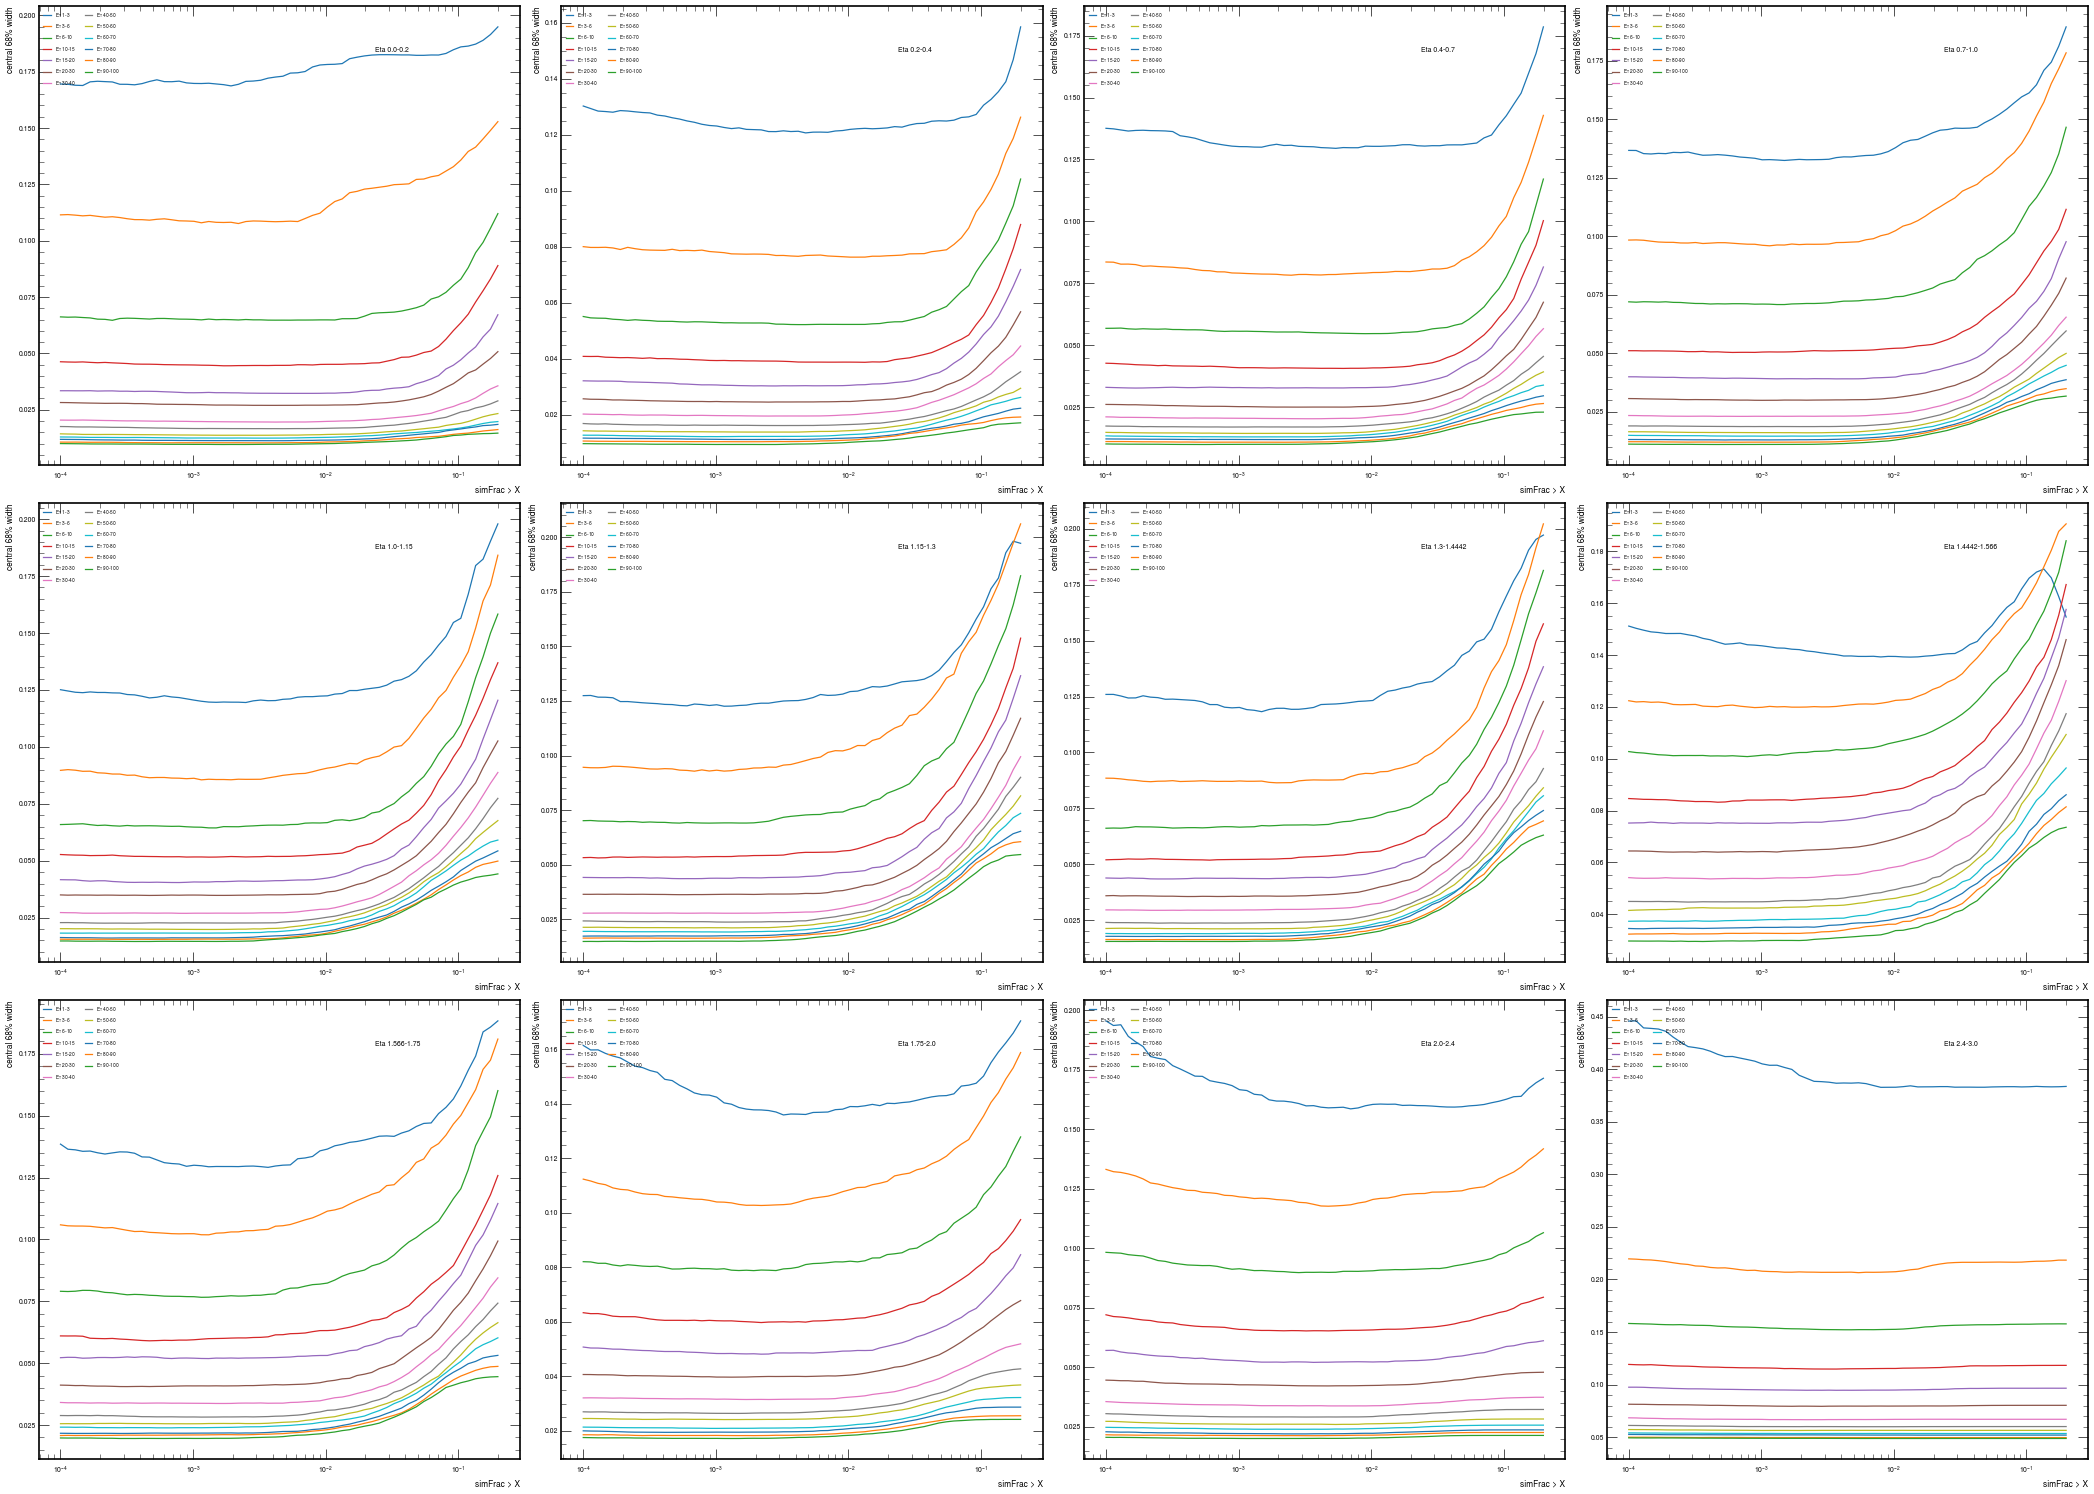

In [36]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.7,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Width_all.png')
f.savefig(outputdir+'/Width_all.pdf')

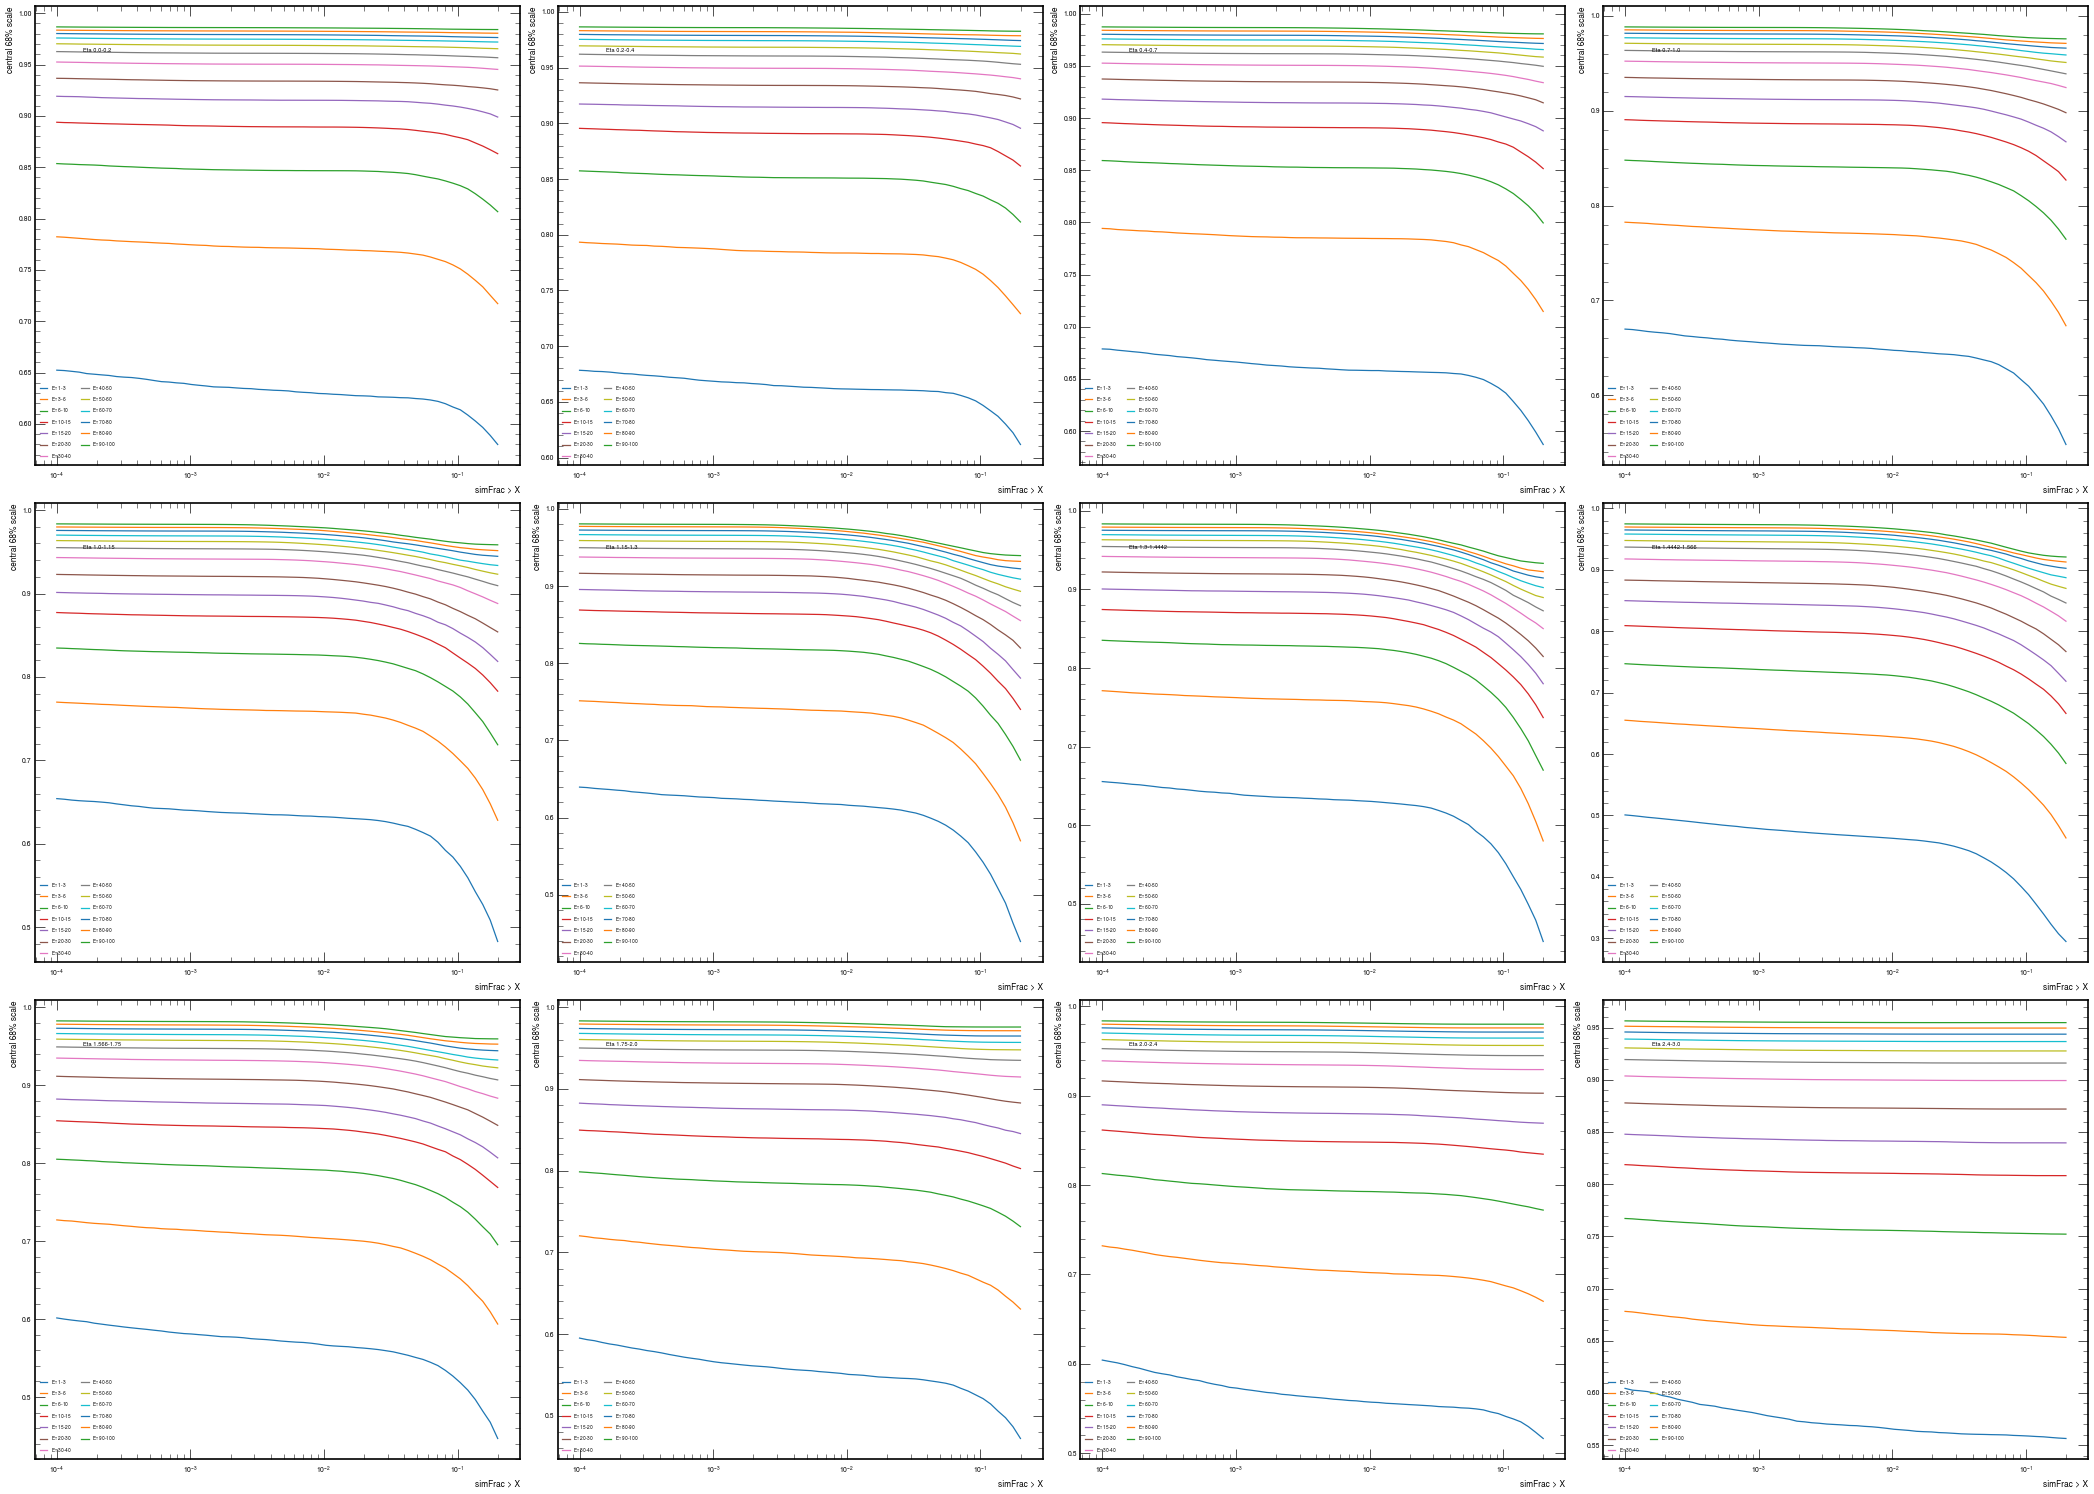

In [37]:
f, axs = plt.subplots(3,4, figsize=(35,25), dpi=60)

for i in range(len(etas)-1):   
    ax = axs[i//4][i% 4]
    for y in range(len(ets)-1):
        a = res[(res.eta_bin == i) & (res.et_bin==y)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$E_T$ {}-{}'.format(ets[y], ets[y+1]))
        
    ax.text(0.1,0.9, "Eta {}-{}".format(etas[i],etas[i+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% scale")
    ax.set_xlabel("simFrac > X")
#     ax.set_xlim(0.001, 0.05)
    ax.set_xscale("log")

f.tight_layout()
f.savefig(outputdir+'/Scale_all.png')

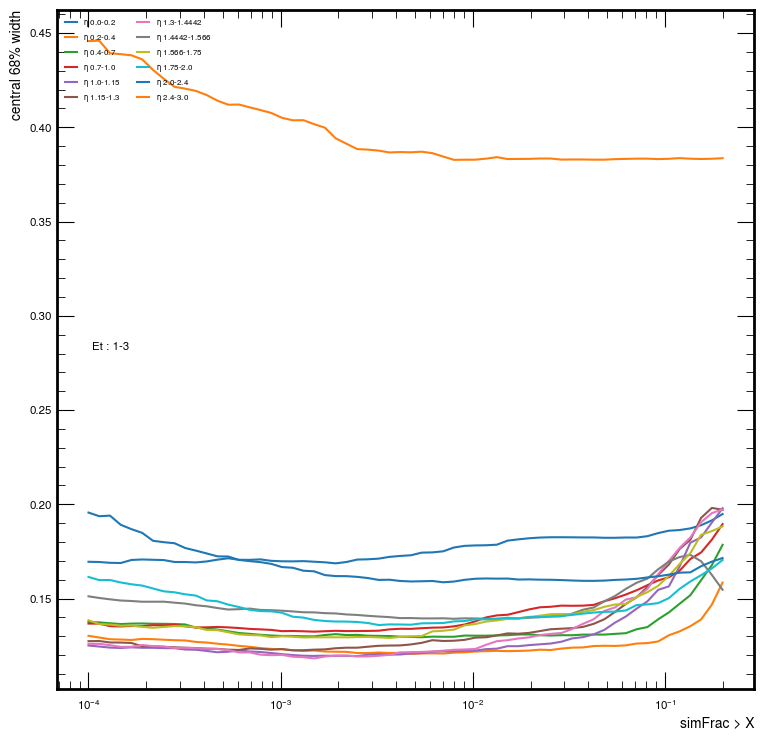

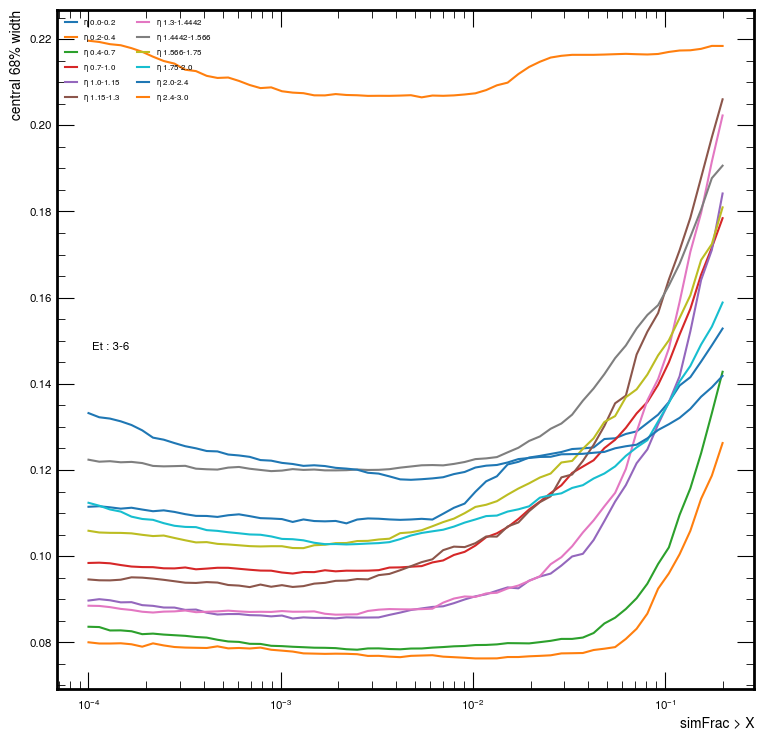

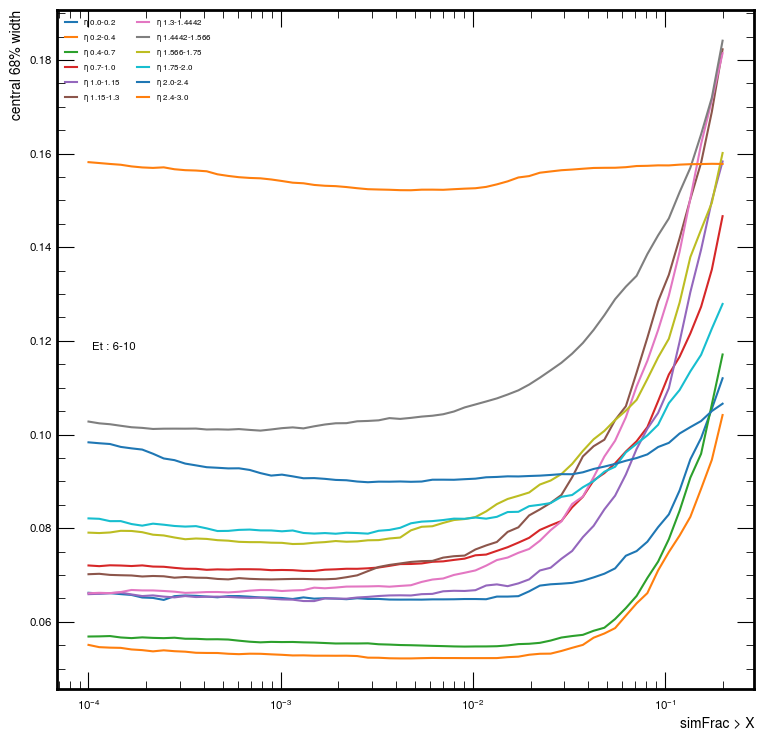

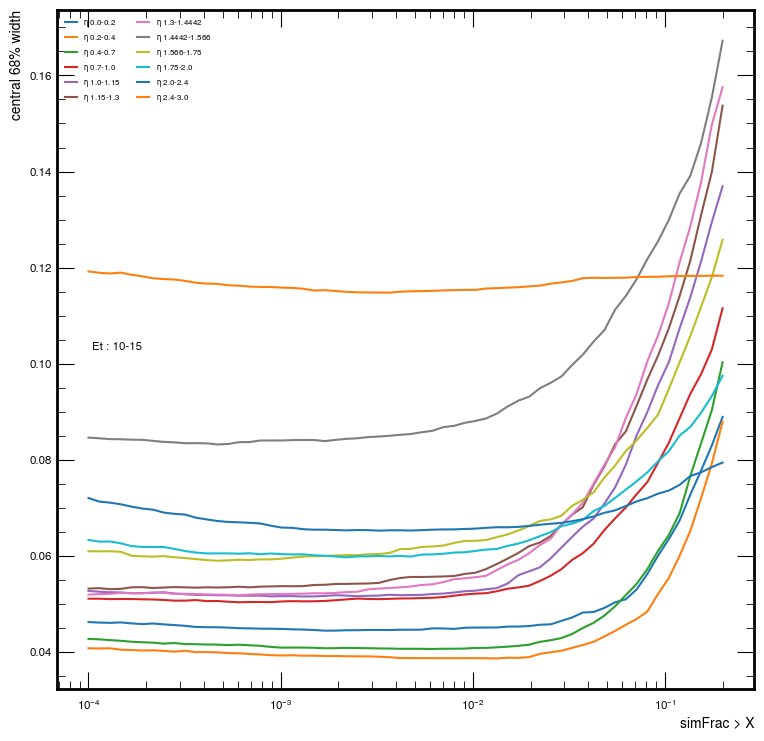

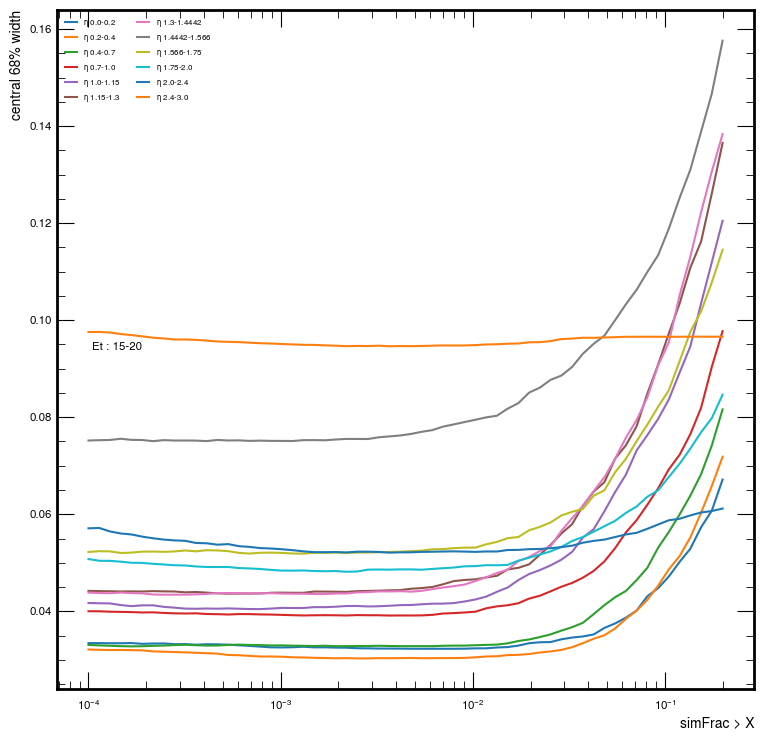

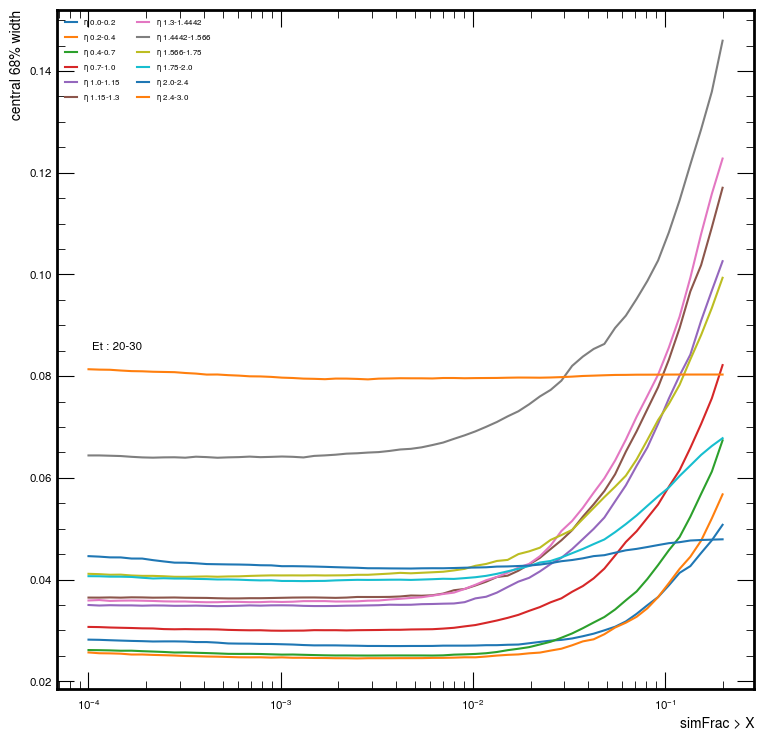

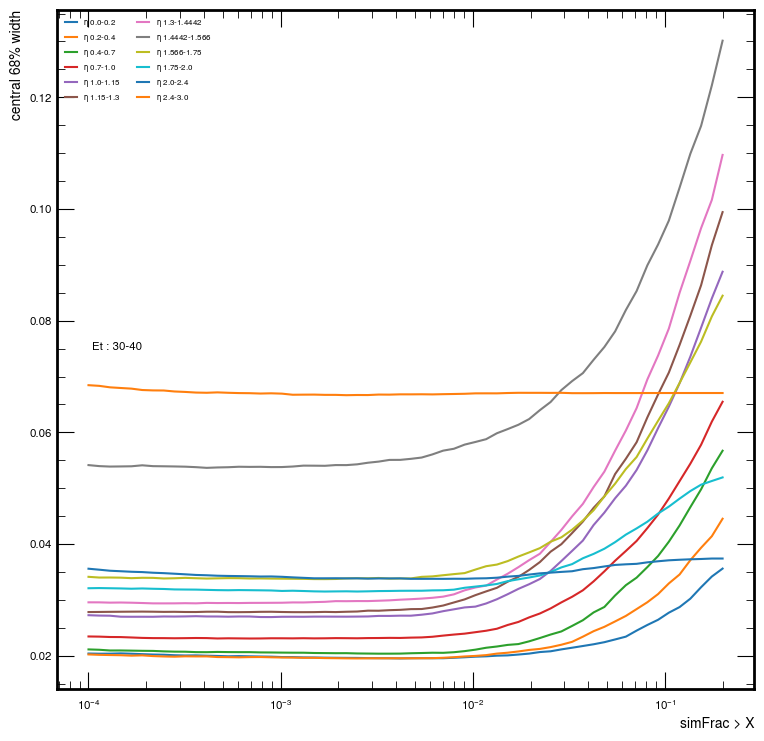

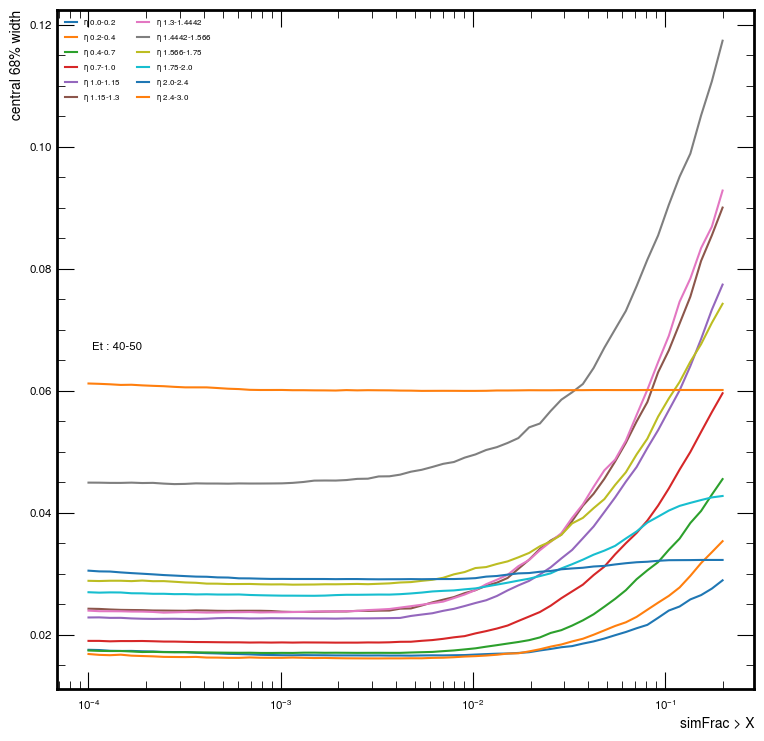

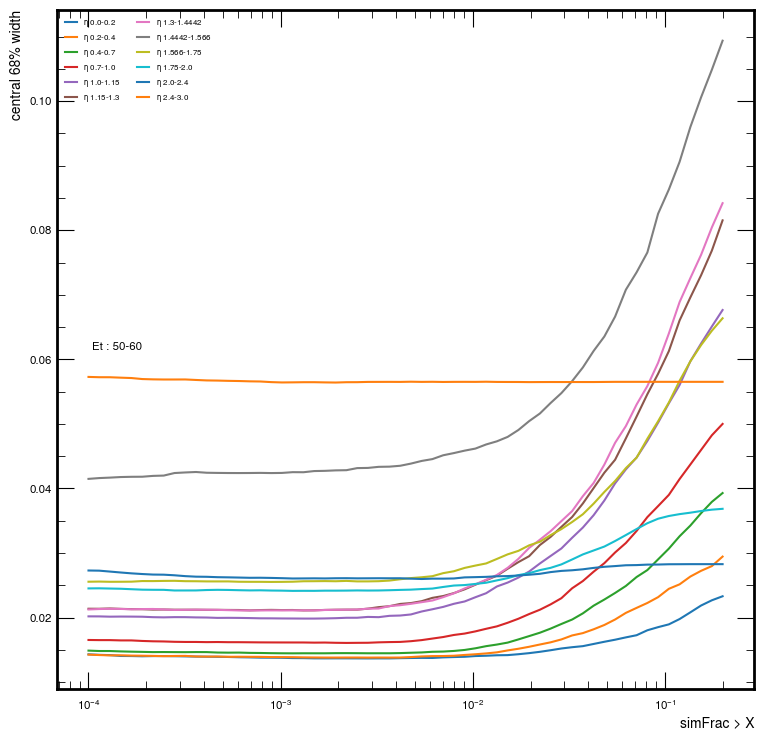

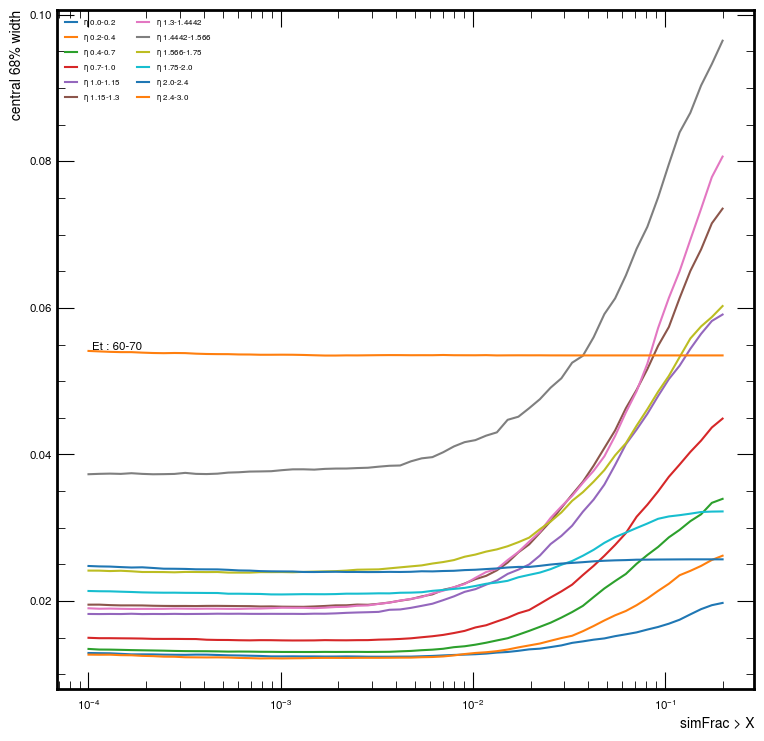

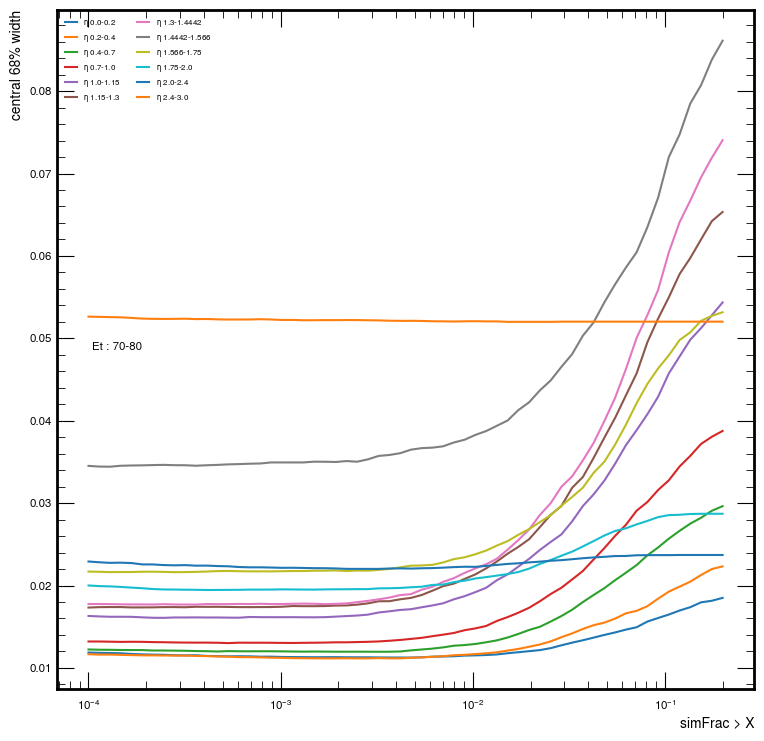

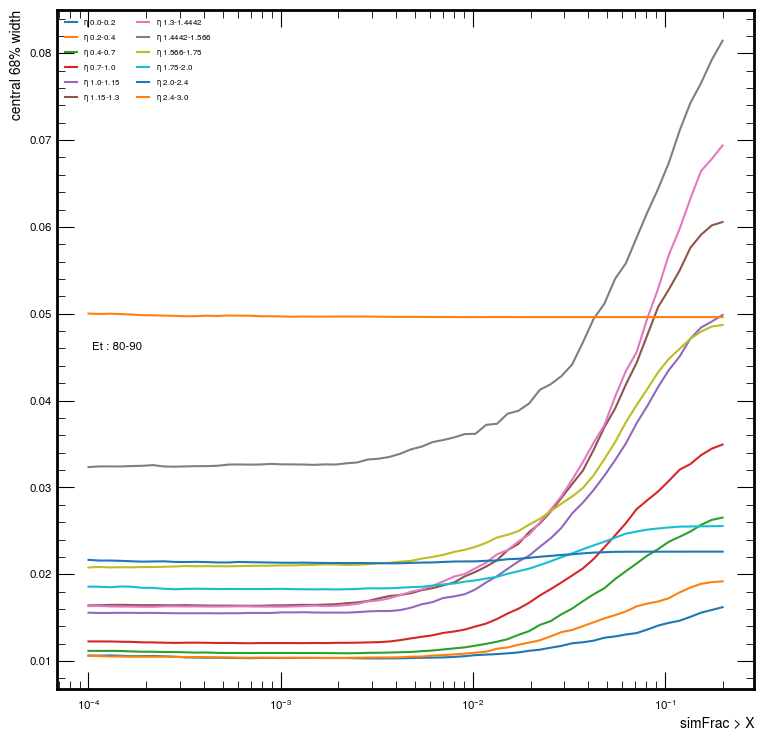

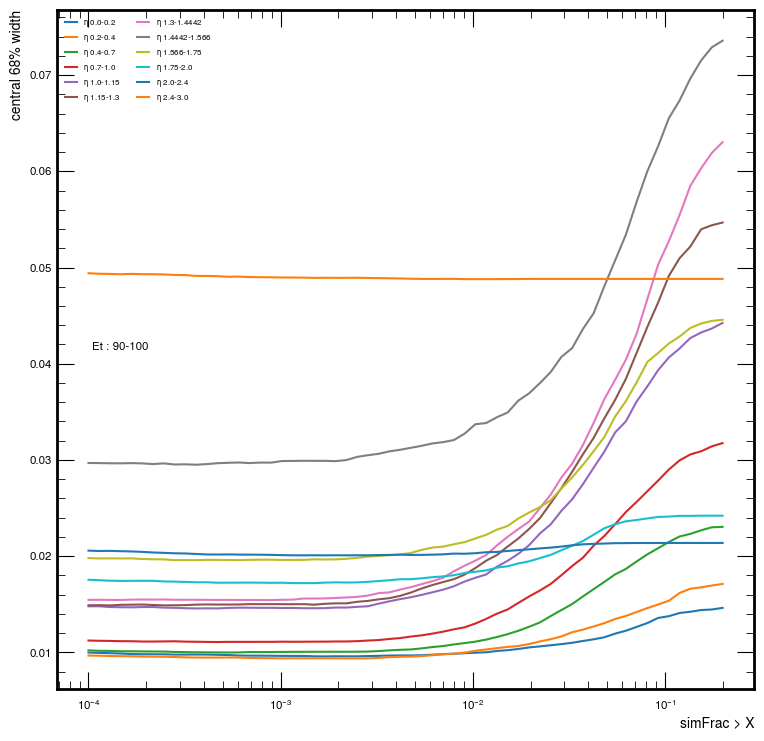

In [38]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68width, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='upper left', ncol=2)
    ax.set_ylabel("central 68% width")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Width_Et{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Width_Et{}_{}.pdf'.format(ets[iet],ets[iet+1]))

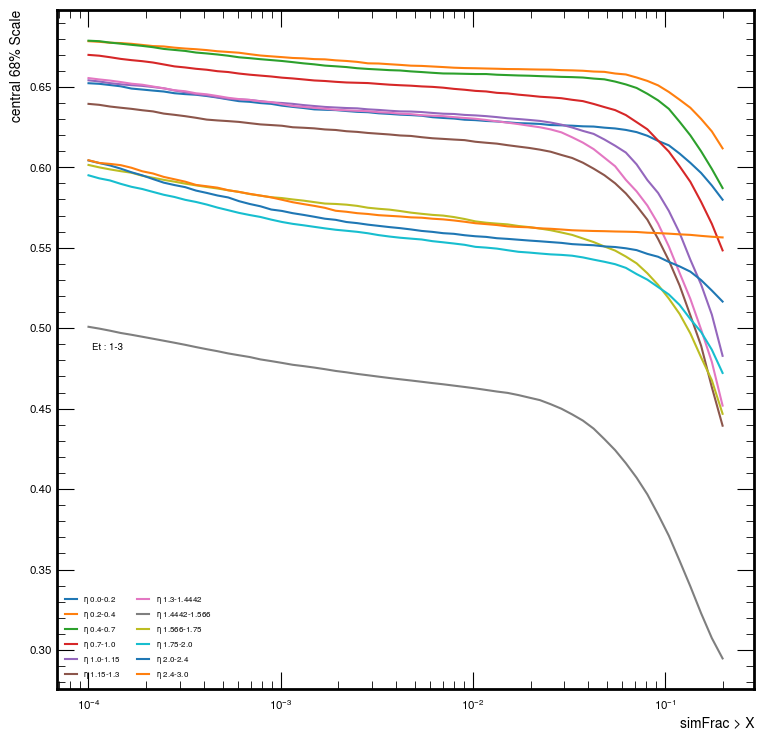

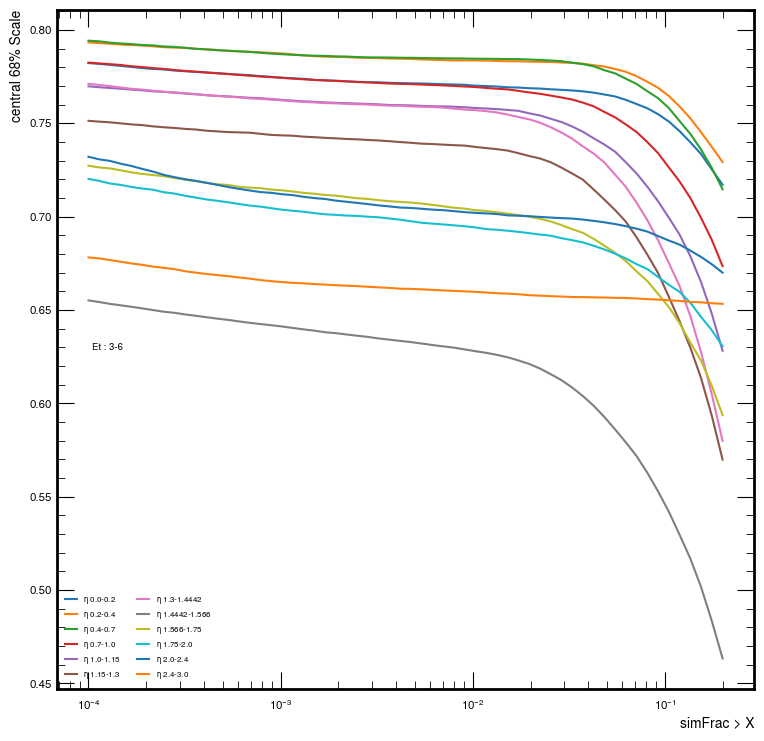

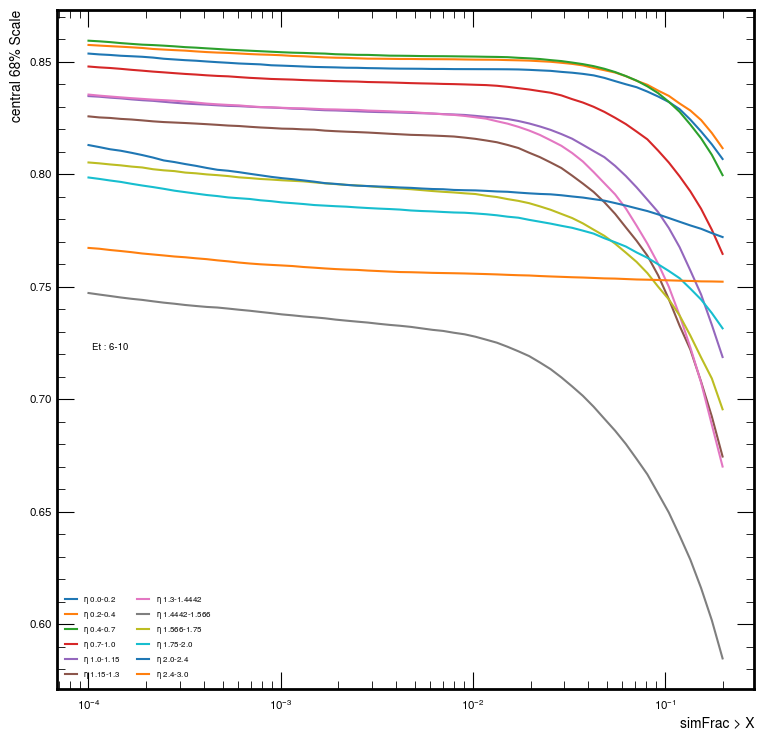

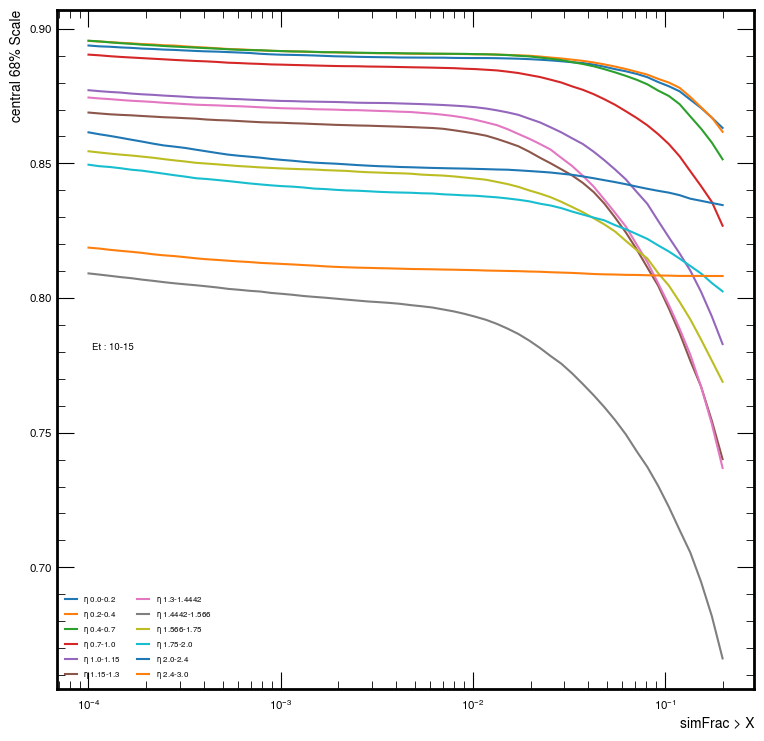

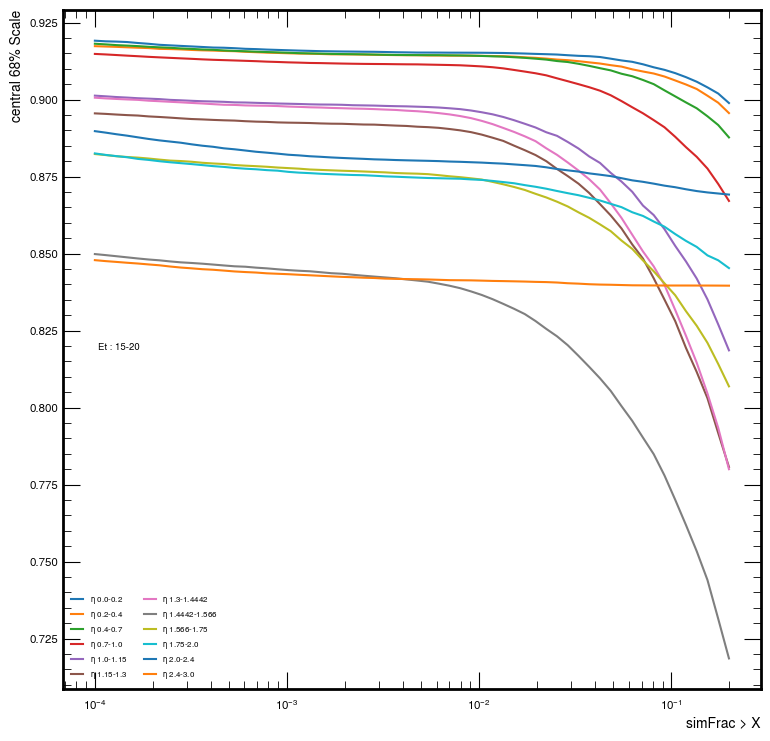

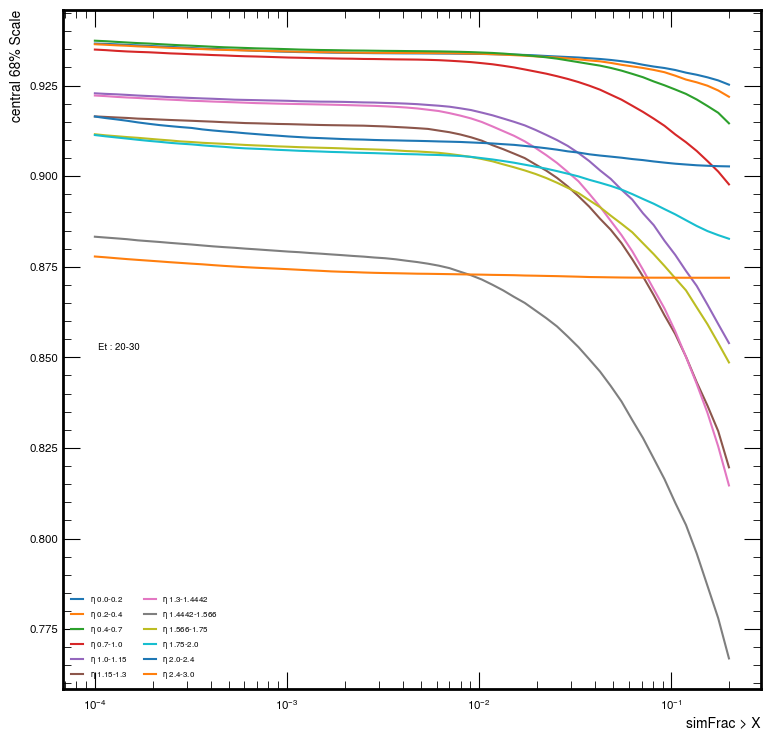

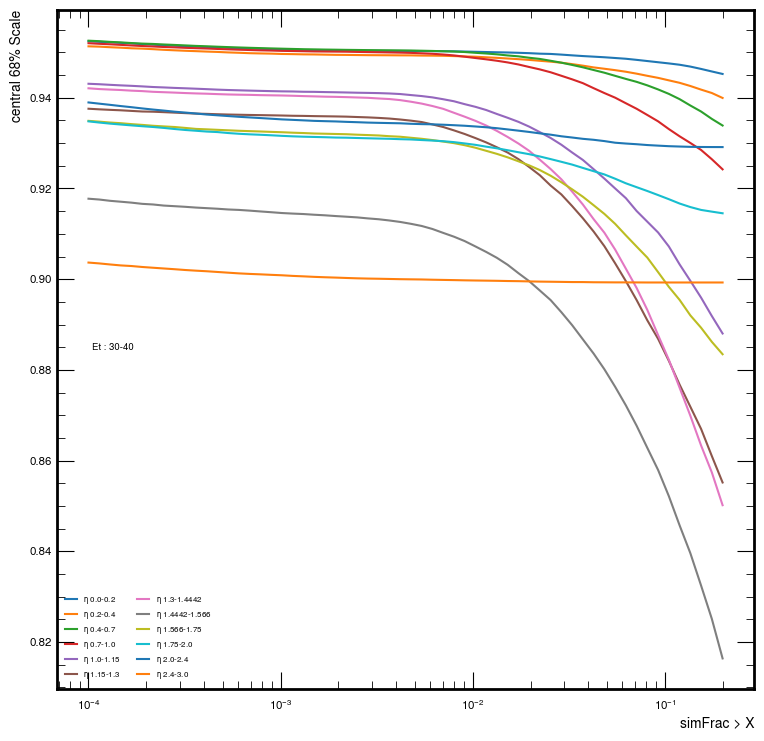

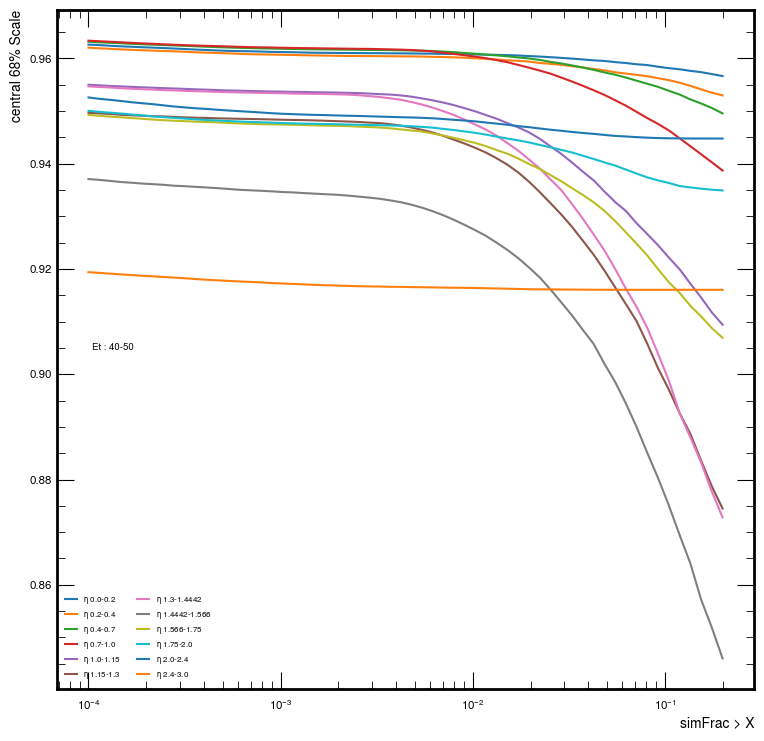

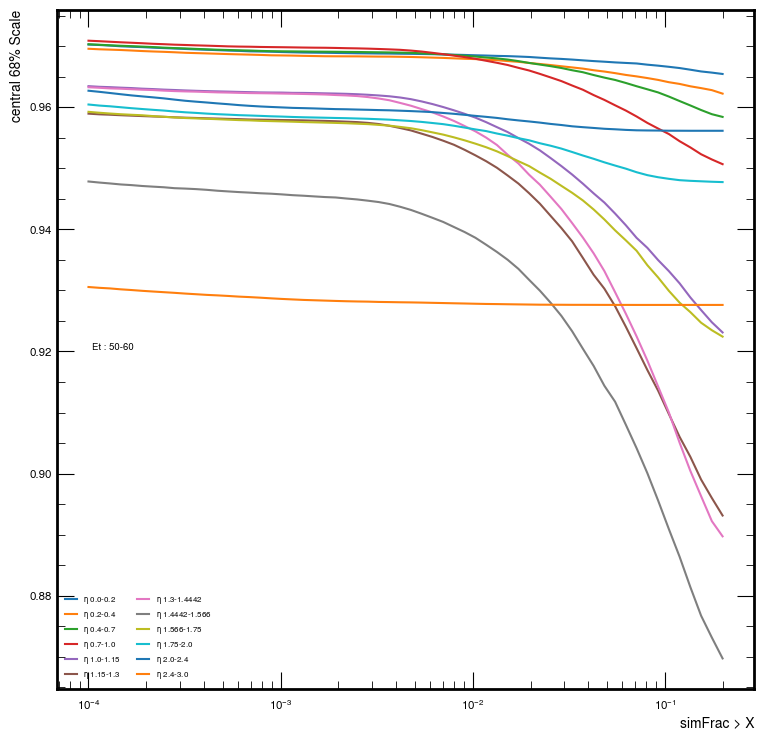

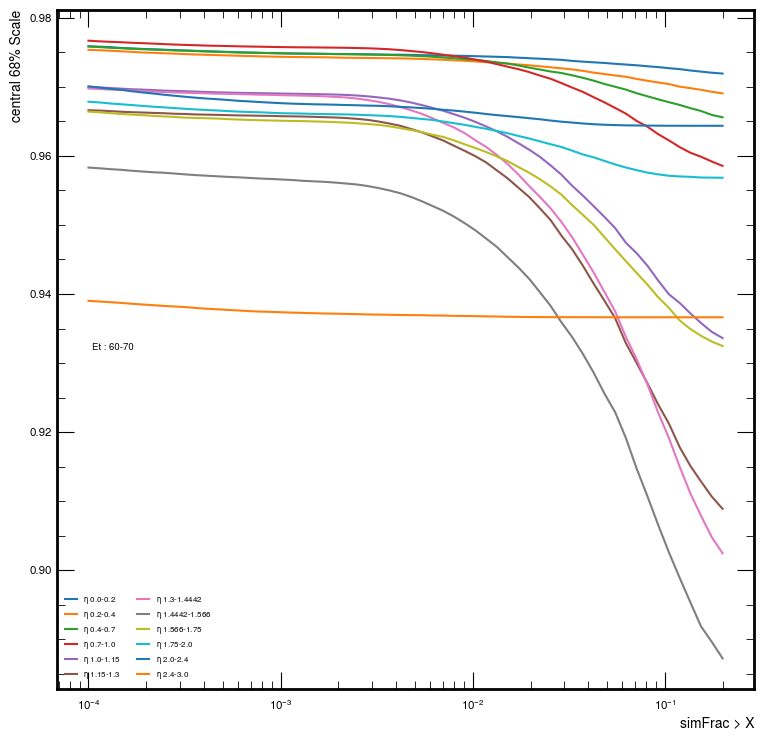

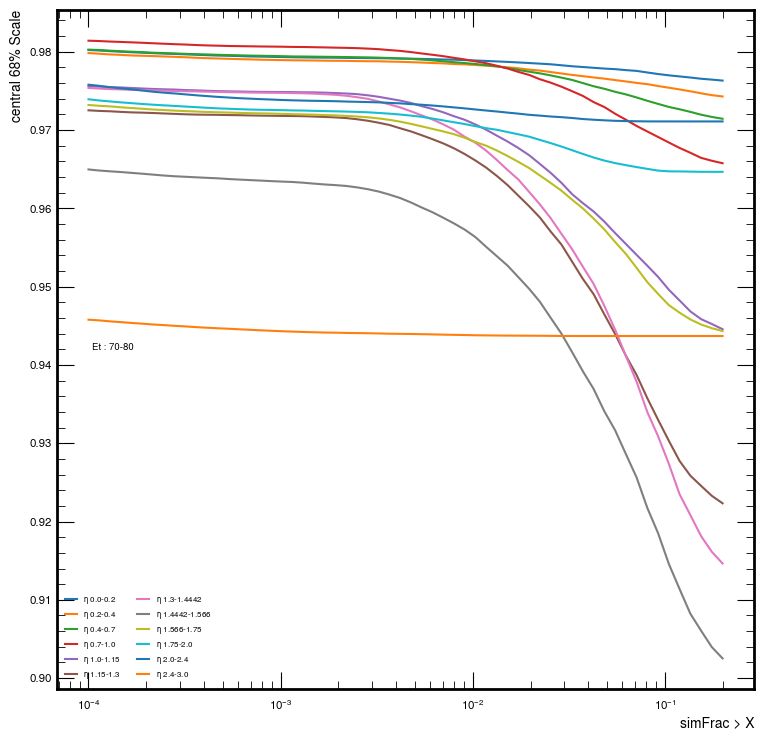

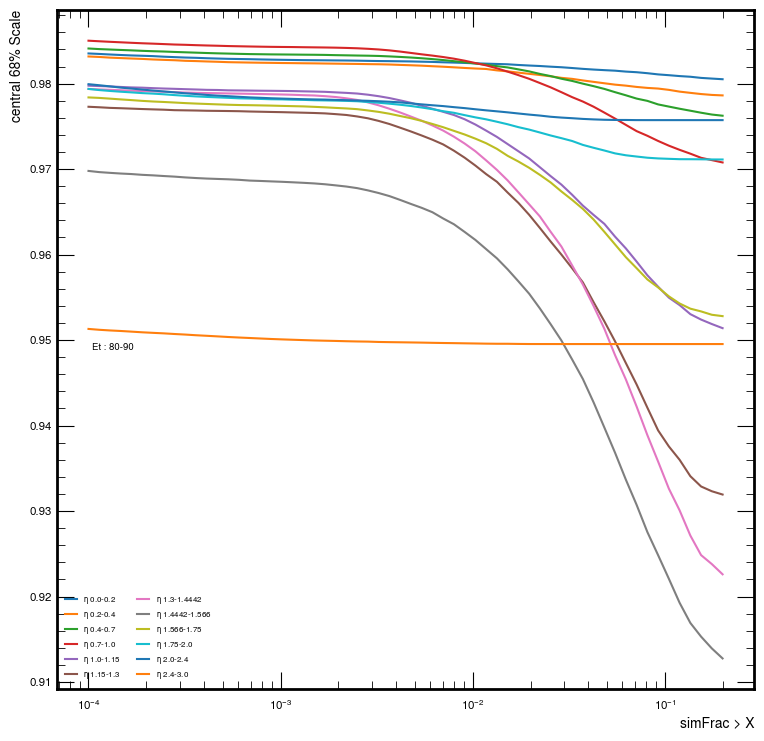

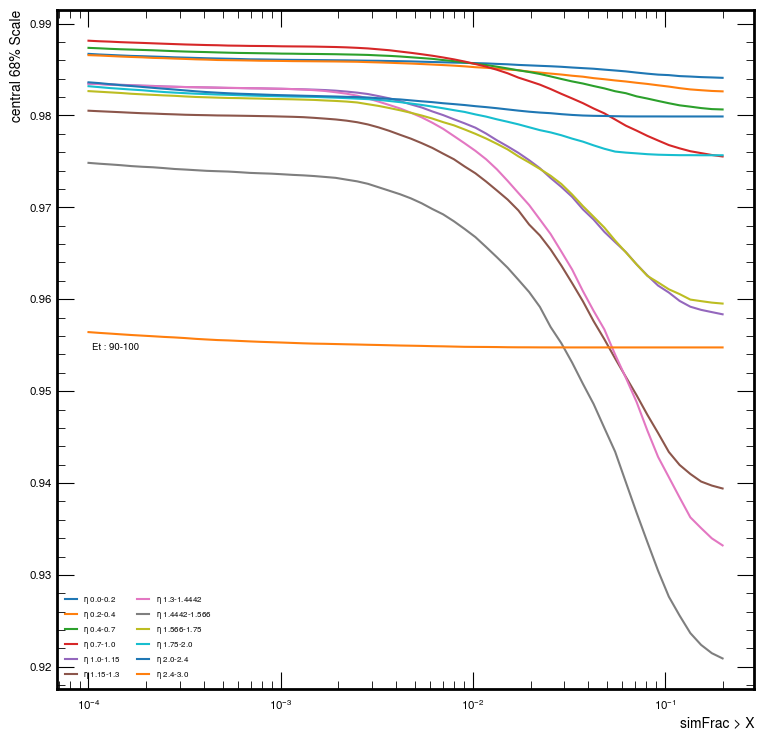

In [39]:
for iet in range(len(ets)-1):
    f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

    for i in range(len(etas)-1): 
        a = res[(res.eta_bin == i) & (res.et_bin==iet)]
        ax.plot(a.thr, a.EoEtrue_68scale, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]))

    ax.text(0.05,0.5, "Et : {}-{}".format(ets[iet],ets[iet+1]),fontsize="x-small", transform=ax.transAxes)
    ax.legend(fontsize="xx-small", loc='lower left', ncol=2)
    ax.set_ylabel("central 68% Scale")
    ax.set_xlabel("simFrac > X")
    #     ax.set_xlim(0.01, 1000)
    ax.set_xscale("log")

    f.savefig(outputdir+'/Scale_{}_{}.png'.format(ets[iet],ets[iet+1]))
    f.savefig(outputdir+'/Scale_{}_{}.pdf'.format(ets[iet],ets[iet+1]))

# Summary thresholds
Now we check which threshold corresponds to the best truth resolution in each eta/pt bin

In [40]:
def bin_analysis_summary(df):
    line = df.iloc[df["EoEtrue_68width"].argmin()]
    return pd.Series({
        "thr": line['thr'],
        "scale": line["EoEtrue_68width"],
        "width": line["EoEtrue_68width"],
        "rel_err" : line["rel_err"]
    })

a = res.groupby(['et_bin','eta_bin']).apply(bin_analysis_summary)
a.reset_index(level=0, inplace=True)
a.reset_index(level=0, inplace=True)

In [41]:
simfrac_thr = a
simfrac_thr.to_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";", index=False)

In [42]:
#loading
simfrac_thr = pd.read_csv(outputdir+ "/best_resolution_simfrac_threshold.csv", sep=";")

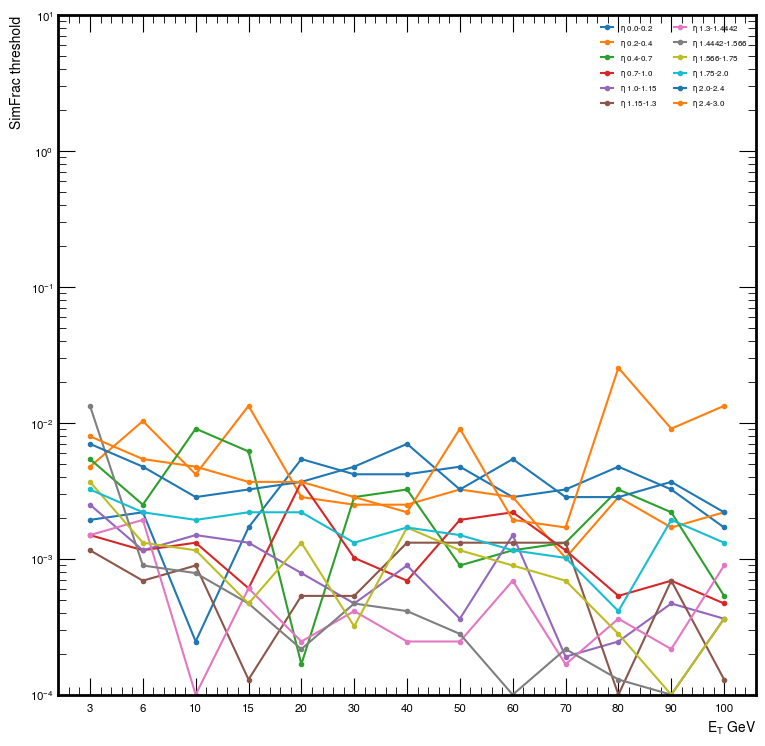

In [43]:
f, ax = plt.subplots(1,1, figsize=(9,9), dpi=100)

for i in range(len(etas)-1): 
    b = a[a.eta_bin == i]
    ax.plot(b.et_bin, b.thr, label='$\eta$ {}-{}'.format(etas[i], etas[i+1]), marker=".")

ax.legend(fontsize="xx-small", loc='upper right', ncol=2)
ax.set_ylabel("SimFrac threshold")
ax.set_xlabel("$E_T$ GeV")
ax.set_ylim(1e-4, 10)
ax.set_yscale("log")
ax.set_xticks(list(range(len(ets)-1)))
ax.set_xticklabels(["{}".format(et) for et in ets[1:]])

f.savefig(outputdir+'/Scale_all_min.png')

ValueError: Passing a Normalize instance simultaneously with vmin/vmax is not supported.  Please pass vmin/vmax directly to the norm when creating it.

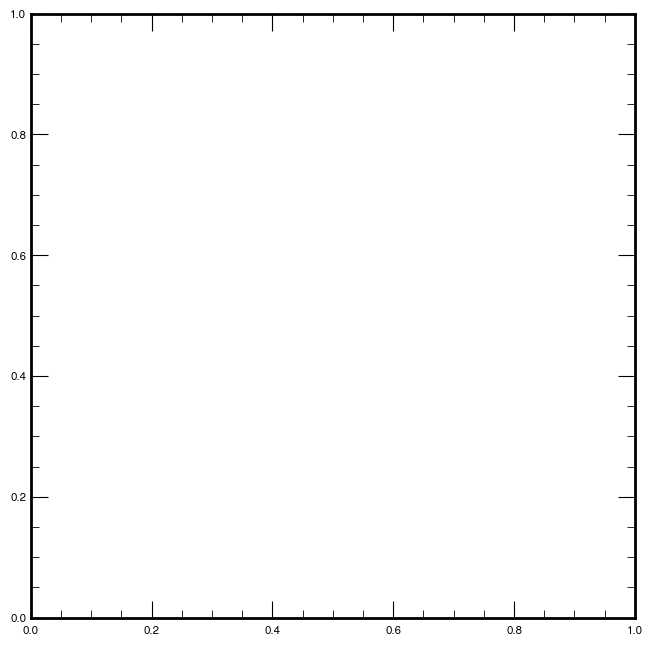

In [44]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.thr.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", norm=LogNorm(vmin=1e-4, vmax=0.06), origin="lower", vmin=1e-4)
plt.colorbar(label="simFraction threshold")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map.png")
f.savefig(outputdir+ "/simfraction_map.pdf")

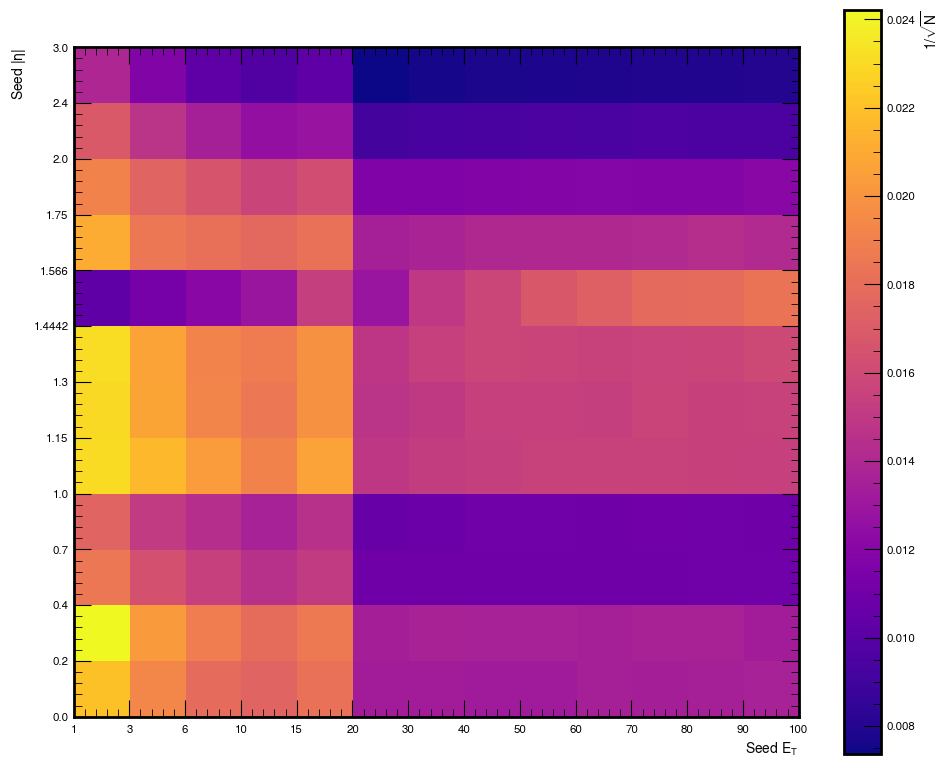

In [45]:
f = plt.figure(figsize=(10,8), dpi=100)
c = a.rel_err.values.reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="$1 / \sqrt{N}$")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_relerr.png")

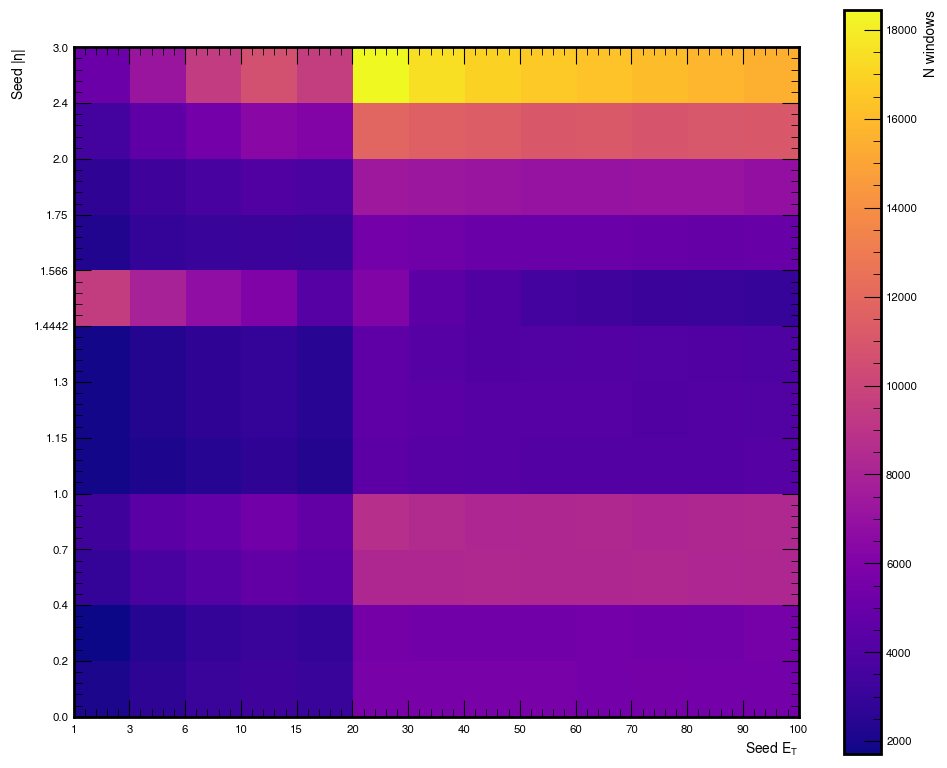

In [46]:
f = plt.figure(figsize=(10,8), dpi=100)
c = np.square((1/ a.rel_err).values).reshape((len(ets)-1, len(etas)-1))
plt.imshow(c.T, cmap="plasma", origin="lower")
plt.colorbar(label="N windows")
plt.xlabel("Seed $E_T$")
plt.ylabel("Seed $|\eta|$")
plt.xticks(np.arange(len(ets))-0.5, [ "{}".format(e) for e in ets])
plt.yticks(np.arange(len(etas))-0.5, [ "{}".format(e) for e in etas])
f.tight_layout()
f.savefig(outputdir+ "/simfraction_map_Nwindows.png")

# Save histogram

Welcome to JupyROOT 6.30/04


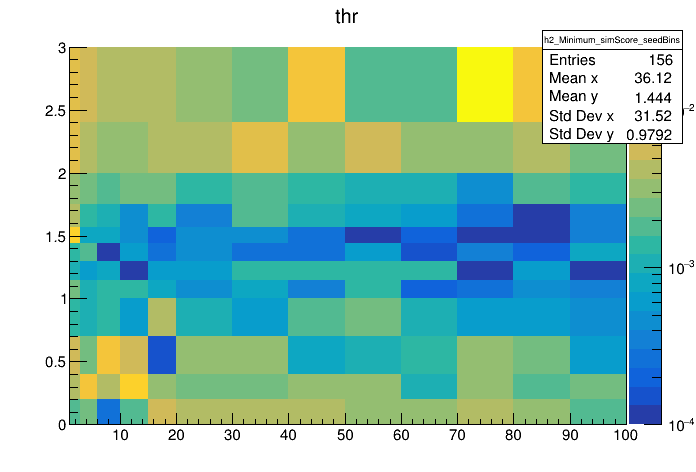

In [47]:
import ROOT as R
from array import array

h2 = R.TH2F("h2_Minimum_simScore_seedBins", "thr", len(ets)-1, array("d", ets), len(etas)-1, array("d", etas))

for _, row in a.iterrows():
    h2.SetBinContent(h2.FindBin(ets[int(row.et_bin)], etas[int(row.eta_bin)]), row.thr)
    
c = R.TCanvas()
h2.Draw("COLZ")
c.SetLogz()
c.Draw()

out = R.TFile(outputdir+"/simScore.root","RECREATE")
h2.Write()
out.Close()

We loop on all the eta and et bins and apply the best threshold. Then we take the maximum dphi and deta from the seed to study the dimension of the window

# Window dimension after simFraction selection 
## Dimension by eta and Et

In [48]:
# Requiring a minimum of 1% of simFraction for the seeds for quality
dfb = dfa[(dfa.seed_simfrac_sig > 0.01)]  # Do now require any geometrical window limit  & (dfa.in_window)
dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))

/tmp/ipykernel_1016/1387350978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["et_bin"] = pd.cut(dfb["seed_et"], ets, labels=list(range(len(ets)-1)))
/tmp/ipykernel_1016/1387350978.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfb["eta_bin"] = pd.cut(dfb["seed_eta"].abs(), etas, labels=list(range(len(etas)-1)))


In [49]:
results = []
for (iet, ieta), g in  dfb.groupby(["et_bin", "eta_bin"]):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)&(simfrac_thr.et_bin == iet)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": 'max' ,
                         "deta_seed": "max", 
                    })
    A["ieta"] = ieta
    A["iet"] = iet
    results.append(A)
    
WS = pd.concat(results)

Text(1, 0, 'Max $\\Delta\\phi(cl-seed)$')

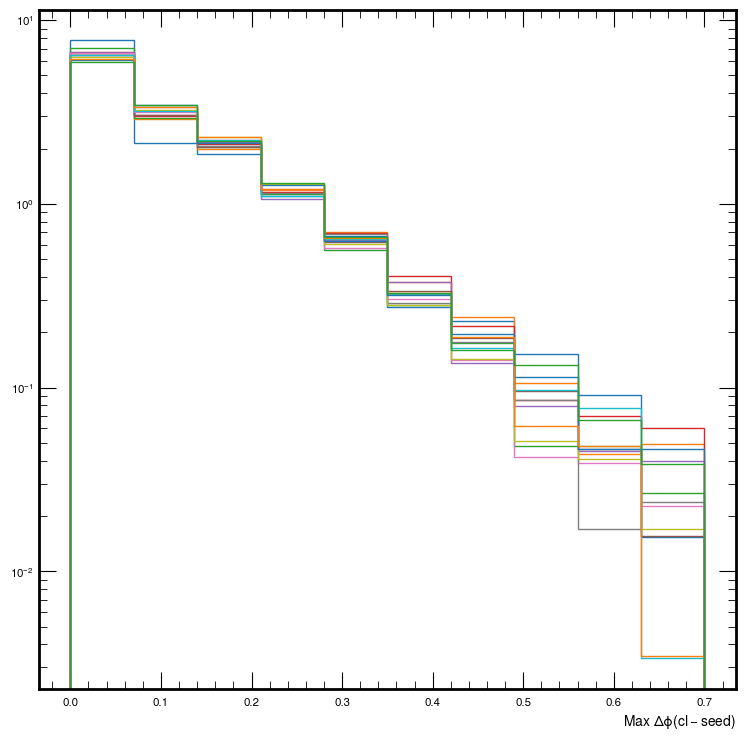

In [50]:
nEt = len(ets)-1
nEta = len(etas)-1
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].dphi_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.7), bins=10, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\phi(cl-seed)$")
#ax.legend()

Text(1, 0, 'Max $\\Delta\\eta(cl-seed)$')

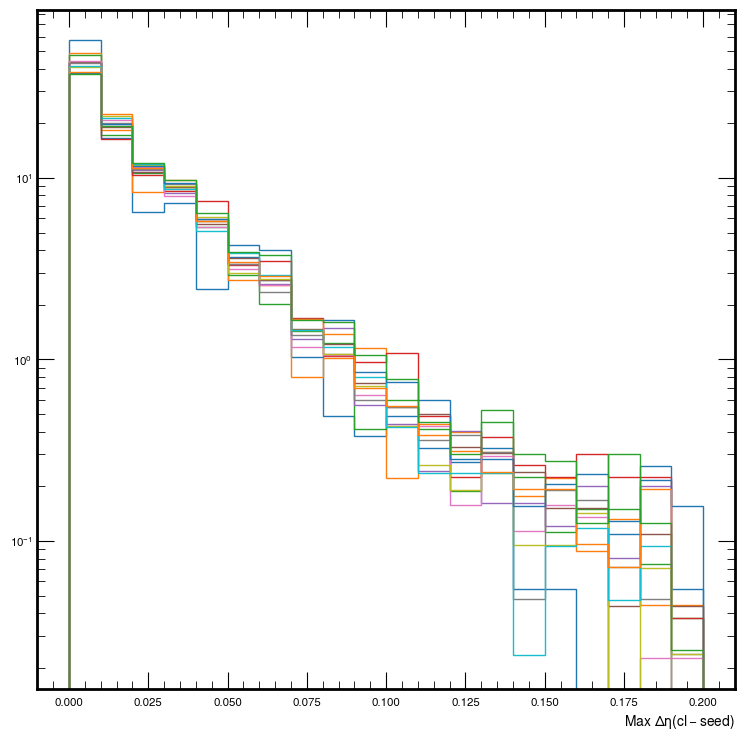

In [51]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
iEta = 5
for iEt in range(nEt):
    ax.hist(WS[(WS.iet==iEt)&(WS.ieta==iEta)].deta_seed, 
             label=f"$\eta$=[{etas[iEta]},{etas[iEta+1]}], $E_T$=[{ets[iEt]},{ets[iEt+1]}]",
             range=(0, 0.2), bins=20, histtype="step", density=True)
ax.set_yscale("log")
ax.set_xlabel("Max $\Delta\eta(cl-seed)$")
#ax.legend()

## Only by seed Eta

In [52]:
results = []
for ieta, g in  dfb.groupby("eta_bin"):
    #print(f"Working on Et:{iet}, Eta:{ieta}")
    thr = simfrac_thr[(simfrac_thr.eta_bin == ieta)].thr
    A =  g[(g.simfrac_sig >  thr.values[0]) | (g.is_seed==1) ].groupby("window_index", sort=False).agg(
                        {
                         "dphi_seed": [np.min, np.max],
                         "deta_seed":  [np.min, np.max]
                    })
    A["ieta"] = ieta
    results.append(A)
    
WS_etaonly = pd.concat(results)

In [53]:
WS_etaonly.dphi_seed.amin

window_index
gujjgvje    0.0
znevjbft    0.0
oxzokaox    0.0
khjiygin    0.0
csukdfmj    0.0
           ... 
krqtncab    0.0
bhrmcjdl    0.0
otsuxmga    0.0
wbvuzcgh    0.0
kgngqgsg    0.0
Name: amin, Length: 3913512, dtype: float64

In [54]:
maxq = 0.995
maxWS_eo = WS_etaonly.groupby('ieta').apply(lambda df: pd.Series(
    {"dphi_min": df.dphi_seed.amin.quantile(1-maxq),
     "dphi_max": df.dphi_seed.amax.quantile(maxq),
     "deta_min": df.deta_seed.amin.quantile(1-maxq),
     "deta_max": df.deta_seed.amax.quantile(maxq)}))

maxWS_eo.reset_index(level=0, inplace=True)
maxWS_eo.reset_index(level=0, inplace=True)

Text(0, 1, '$\\Delta\\phi$')

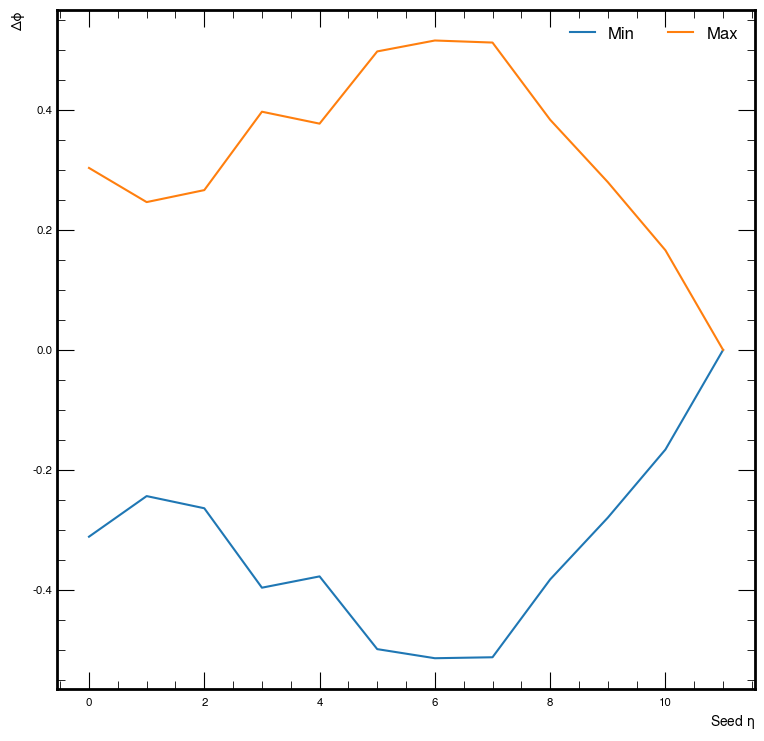

In [55]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.dphi_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\phi$")

Text(0, 1, '$\\Delta\\eta$')

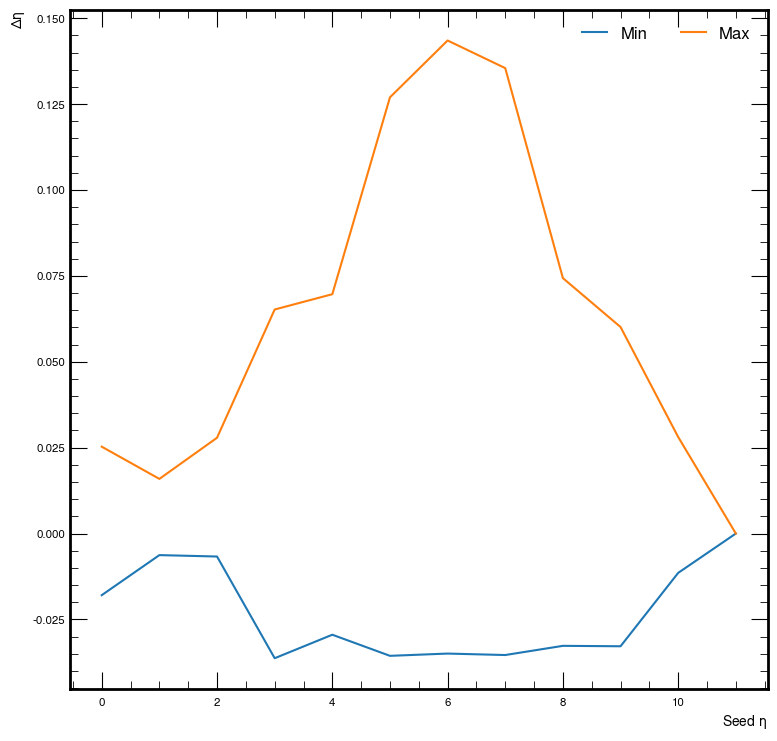

In [56]:
f, ax  = plt.subplots(1,1, figsize=(9,9), dpi=100)

ax.plot(maxWS_eo.ieta, maxWS_eo.deta_min, label="Min")
ax.plot(maxWS_eo.ieta, maxWS_eo.deta_max, label="Max")

ax.legend(ncol=3, fontsize="12")
#ax.set_xticklabels(etas)
ax.set_xlabel("Seed $\eta$")
ax.set_ylabel("$\Delta\eta$")